# **Part 1: Stock Closing Price Prediction Challenge**

## **Challenge Description**
The goal of this challenge is to develop a machine learning model that predicts a stock's closing price **5 trading days into the future** using a provided historical stock price dataset. The solution should demonstrate both **predictive accuracy** and **practical trading value**.

## **Key Requirements**
1. **Exploratory Data Analysis (EDA):**
   - Perform EDA to identify relevant patterns and features.
   - Visualize key patterns, trends, seasonality, and anomalies in the data.
   - Justify feature selection and document data preprocessing decisions.

2. **Feature Engineering:**
   - Engineer meaningful features from the time series data.

3. **Model Development:**
   - Develop and train a prediction model.
   - Compare different modeling approaches and justify the final model choice.

4. **Model Evaluation:**
   - Evaluate the model using statistical metrics (e.g., RMSE, directional accuracy).
   - Simulate trading performance to assess practical value.

5. **Documentation:**
   - Present the approach, including feature importance and model limitations.
   - Identify limitations and propose improvement strategies.

## **Deliverables**
1. **Jupyter Notebook:**
   - Well-documented code showing the complete workflow from data analysis to prediction.

2. **EDA Report:**
   - Visualizations of key patterns and relationships.
   - Analysis of trends, seasonality, and anomalies.
   - Justification for feature selection and preprocessing decisions.

3. **Model Selection Documentation:**
   - Comparison of different modeling approaches.
   - Explanation of evaluation metrics and final model choice.
   - Analysis of model limitations and potential improvements.

4. **CSV File:**
   - Predictions for the test period.

5. **README File:**
   - Summary of the approach, key findings, and instructions to reproduce results.

***First of all let's import the relevent libraries***

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from statsmodels.graphics.tsaplots import month_plot
from sklearn.preprocessing import MinMaxScaler
from scipy.stats.mstats import winsorize
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import lag_plot
import plotly.graph_objs as go
import plotly.offline as py
import mplfinance as mpf
import os
from datetime import datetime

import warnings
warnings.filterwarnings('ignore',category=Warning)

## **Data Load and Get Basic Info**

In [3]:
df = pd.read_csv("../data/question4-stock-data.csv")
df['Date'] = pd.to_datetime(df['Date']) # convert to datetime

In [3]:
# print the 1 st 5 rows of the dataframe

df.head(5)

,Unnamed: 0,Date,Adj Close,Close,High,Low,Open,Volume
0,0,1980-03-17,2.296798,3.291227,3.344743,3.291227,0.000000,41109.0
1,1,1980-03-18,2.306134,3.304606,3.358122,3.304606,0.000000,9343.0
2,2,1980-03-19,2.306134,3.304606,3.304606,3.304606,3.304606,0.0
3,3,1980-03-20,2.306134,3.304606,3.358122,3.304606,0.000000,10277.0
4,4,1980-03-21,2.362154,3.384880,3.438396,3.384880,0.000000,8409.0


In [4]:
# get statistical information of the dataframe

df.describe(include='number')

,Unnamed: 0,Adj Close,Close,High,Low,Open,Volume
count,11291.000000,11198.000000,11174.000000,11196.000000,11164.000000,11188.000000,1.114600e+04
mean,5645.000000,63.609130,72.026945,72.503100,71.665079,67.999259,2.144157e+05
std,3259.575279,52.266247,51.259828,51.550735,51.011632,55.834401,3.883662e+05
min,0.000000,2.259452,3.237711,3.237711,3.237711,0.000000,0.000000e+00
25%,2822.500000,19.224636,27.500000,27.789255,27.536156,0.000000,1.350000e+04
50%,5645.000000,50.608900,66.035000,66.724998,65.418751,66.065002,9.032350e+04
75%,8467.500000,104.723621,114.297503,114.892500,113.639999,114.269997,2.915750e+05
max,11290.000000,254.770004,254.770004,255.229996,253.589996,255.000000,1.858270e+07


In [5]:
# check for missing values and data types of the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11291 entries, 0 to 11290
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  11291 non-null  int64         
 1   Date        11181 non-null  datetime64[ns]
 2   Adj Close   11198 non-null  float64       
 3   Close       11174 non-null  float64       
 4   High        11196 non-null  float64       
 5   Low         11164 non-null  float64       
 6   Open        11188 non-null  float64       
 7   Volume      11146 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 705.8 KB




**Missing Values Calculation**

- By analyzing the dataset, we can see that there are a few missing values in some columns. Below is the calculation of missing values in each column:

```python


#  for  the DataFrame
missing_values = df.isnull().sum()
print(missing_values)

```
**Weekend Shop Closure Analysis** 

- By analyzing the dataset, we observe that the shop remains closed on weekends, specifically on **Saturday and Sunday**. This pattern is evident from the absence or significantly lower number of recorded entries on these days.


In [6]:
missing_values = df.isnull().sum()
missing_values

Unnamed: 0      0
Date          110
Adj Close      93
Close         117
High           95
Low           127
Open          103
Volume        145
dtype: int64

## **Handle Missing Values in the Dataset**

In [4]:
# Fill Date missing dates
for i in range(1, len(df)):
    if pd.isna(df.loc[i, 'Date']):  
        next_date = df.loc[i - 1, 'Date'] + pd.Timedelta(days=1)
        
        # Skip Saturdays and Sundays
        while next_date.weekday() in [5, 6]:  # 5 = Saturday, 6 = Sunday
            next_date += pd.Timedelta(days=1)
        
        df.loc[i, 'Date'] = next_date



# Fill missing values in the other columns
df.fillna(method='ffill', inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11291 entries, 0 to 11290
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  11291 non-null  int64         
 1   Date        11291 non-null  datetime64[ns]
 2   Adj Close   11291 non-null  float64       
 3   Close       11291 non-null  float64       
 4   High        11291 non-null  float64       
 5   Low         11291 non-null  float64       
 6   Open        11291 non-null  float64       
 7   Volume      11291 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 705.8 KB


## **Exploratory Data Analysis (EDA)**

In [38]:
class TimeSeriesEDA:
    def __init__(self, df, date_column):
        """
        Initialize the EDA class with a DataFrame and the name of the date column.
        Converts the date column to datetime format and sets it as the index.
        """
        self.df = df.copy()
        self.df[date_column] = pd.to_datetime(self.df[date_column])
        self.df.set_index(date_column, inplace=True)
    
    def plot_time_series(self, column1, column2=None): 
        """
        Plot one or two features against time.
        If column2 is provided, both are plotted on the same figure.
        """
        plt.figure(figsize=(12, 6))
        plt.plot(self.df.index, self.df[column1], label=column1, color='blue')
        if column2:
            plt.plot(self.df.index, self.df[column2], label=column2, color='red')
        plt.title(f'{column1} Over Time' + (f' and {column2}' if column2 else ''))
        plt.xlabel("Date")
        plt.ylabel("Value")
        plt.legend()
        plt.show()
    
    def plot_volume(self, volume_column):
        """
        Plot trading volume over time to identify patterns and outliers.
        """
        plt.figure(figsize=(12, 6))
        plt.plot(self.df.index, self.df[volume_column], label="Volume", color="orange")
        plt.title("Stock Volume Over Time")
        plt.xlabel("Date")
        plt.ylabel("Volume")
        plt.show()
    
    def plot_all_features(self):
        """
        Plot all numeric features over time to observe general trends.
        """
        self.df1 = self.df[["Open", "Close", "High", "Low", "Adj Close"]]
        self.df1.plot(figsize=(20, 8))
        plt.title("Feature Trends Over Time")
        plt.xlabel("Date")
        plt.ylabel("Values")
        plt.grid()
        plt.show()
    
    def plot_box_by_year(self, target_column):
        """
        Boxplot to analyze feature distribution across different years.
        Useful for detecting trends and variations in yearly data.
        """
        _, ax = plt.subplots(figsize=(25, 8))
        sns.boxplot(x=self.df.index.year, y=self.df[target_column], ax=ax)
        plt.title(f'{target_column} Distribution Over Years')
        plt.xlabel('Year')
        plt.ylabel(target_column)
        plt.xticks(rotation=90)
        plt.grid()
        plt.show()
    
    def plot_box_by_month(self, target_column):
        """
        Boxplot to analyze feature distribution across different months.
        Helps identify monthly patterns in the data.
        """
        _, ax = plt.subplots(figsize=(15, 8))
        sns.boxplot(x=self.df.index.month_name(), y=self.df[target_column], ax=ax)
        plt.title(f'{target_column} Distribution Across Months')
        plt.xlabel('Month')
        plt.ylabel(target_column)
        plt.grid()
        plt.show()
    
    def plot_monthly_trends(self, target_column):
        """
        Month plot to visualize seasonal patterns in time series data.
        """
        fig, ax = plt.subplots(figsize=(22, 8))
        period_index = pd.PeriodIndex(self.df.index, freq="M")  # Convert to PeriodIndex
        month_plot(pd.Series(self.df[target_column].values, index=period_index), ylabel=target_column, ax=ax)
        plt.title(f'{target_column} Monthly Trends')
        plt.xlabel("Month")
        plt.ylabel(target_column)
        plt.grid()
        plt.show()

    
    def plot_yearly_avg(self, target_column):
        """
        Line plot of yearly averages to identify long-term trends.
        """
        yearly_avg = self.df[target_column].resample('A').mean()
        yearly_avg.plot(figsize=(12, 6))
        plt.title(f'Yearly Average of {target_column}')
        plt.xlabel("Year")
        plt.ylabel("Average Value")
        plt.grid()
        plt.show()
    
    def plot_quarterly_avg(self, target_column):
        """
        Line plot of quarterly averages to observe intra-year variations.
        """
        quarterly_avg = self.df[target_column].resample('Q').mean()
        quarterly_avg.plot(figsize=(12, 6))
        plt.title(f'Quarterly Average of {target_column}')
        plt.xlabel("Quarter")
        plt.ylabel("Average Value")
        plt.show()
    
    def compute_coefficient_of_variation(self, target_column):
        """
        Compute coefficient of variation (CV) over years to measure volatility.
        """
        df_stats = self.df.groupby(self.df.index.year)[target_column].agg(['mean', 'std'])
        df_stats['CV_pct'] = (df_stats['std'] / df_stats['mean']) * 100
        return df_stats
    
    def plot_coefficient_of_variation(self, target_column):
        """
        Plot coefficient of variation to analyze yearly volatility.
        """
        df_stats = self.compute_coefficient_of_variation(target_column)
        df_stats['CV_pct'].plot(figsize=(12, 6))
        plt.title(f'Yearly Coefficient of Variation of {target_column}')
        plt.xlabel("Year")
        plt.ylabel("CV (%)")
        plt.grid()
        plt.show()
    
    def plot_correlation_heatmap(self):
        """
        Heatmap to visualize correlation between numeric features.
        Helps identify relationships between different variables.
        """
        numeric_df = self.df.select_dtypes(include='number')
        plt.figure(figsize=(8, 6))
        sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
        plt.title('Feature Correlation Heatmap')
        plt.show()

    def plot_rolling_statistics(self, target_column, window=30):
        """
        Plot rolling mean and rolling standard deviation to check for stationarity.
        """
        rolling_mean = self.df[target_column].rolling(window=window).mean()
        rolling_std = self.df[target_column].rolling(window=window).std()
        
        plt.figure(figsize=(12, 6))
        plt.plot(self.df.index, self.df[target_column], label='Original', color='blue')
        plt.plot(self.df.index, rolling_mean, label='Rolling Mean', color='red')
        plt.plot(self.df.index, rolling_std, label='Rolling Std', color='green')
        plt.title(f'Rolling Mean & Standard Deviation of {target_column}')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid()
        plt.show()

    def perform_adf_test(self, target_column):
        """
        Perform Augmented Dickey-Fuller test to check stationarity.
        """
        result = adfuller(self.df[target_column])
        print(f'ADF Statistic: {result[0]}')
        print(f'p-value: {result[1]}')
        print(f'Critical Values: {result[4]}')
        if result[1] <= 0.05:
            print("Reject the null hypothesis: Data is stationary.")
        else:
            print("Fail to reject the null hypothesis: Data is non-stationary.")


    def plot_decomposition(self, target_column, period=365):
        """
        Decompose time series into trend, seasonality, and residuals.
        """
        decomposition = seasonal_decompose(self.df[target_column], period=period)
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))
        decomposition.trend.plot(ax=ax1, title='Trend')
        decomposition.seasonal.plot(ax=ax2, title='Seasonality')
        decomposition.resid.plot(ax=ax3, title='Residuals')
        decomposition.observed.plot(ax=ax4, title='Observed')
        plt.tight_layout()
        plt.show()

    def plot_acf_pacf(self, target_column, lags=40):
        """
        Plot Autocorrelation (ACF) and Partial Autocorrelation (PACF) to identify lagged relationships.
        """
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        plot_acf(self.df[target_column], lags=lags, ax=ax1)
        plot_pacf(self.df[target_column], lags=lags, ax=ax2)
        plt.tight_layout()
        plt.show()

    def plot_cumulative_returns(self, target_column):
        """
        Plot cumulative returns of the stock over time.
        """
        cumulative_returns = (1 + self.df[target_column].pct_change()).cumprod()
        cumulative_returns.plot(figsize=(12, 6))
        plt.title('Cumulative Returns Over Time')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Returns')
        plt.grid()
        plt.show()

    def plot_rolling_volatility(self, target_column, window=30):
        """
        Plot rolling volatility (standard deviation) of the stock price.
        """
        rolling_volatility = self.df[target_column].rolling(window=window).std()
        rolling_volatility.plot(figsize=(12, 6))
        plt.title(f'Rolling Volatility (Window={window})')
        plt.xlabel('Date')
        plt.ylabel('Volatility')
        plt.grid()
        plt.show()

    def plot_histogram(self, target_column):
        """
        Plot histogram to analyze the distribution of a feature.
        """
        plt.figure(figsize=(12, 6))
        sns.histplot(self.df[target_column], kde=True, color='blue')
        plt.title(f'Distribution of {target_column}')
        plt.xlabel(target_column)
        plt.ylabel('Frequency')
        plt.grid()
        plt.show()

    def plot_kde(self, target_column):
        """
        Plot KDE to analyze the distribution of a feature.
        """
        plt.figure(figsize=(12, 6))
        sns.kdeplot(self.df[target_column], color='blue')
        plt.title(f'KDE of {target_column}')
        plt.xlabel(target_column)
        plt.ylabel('Density')
        plt.grid()
        plt.show()

    def plot_lag(self, target_column, lag=1):
        """
        Plot lag plot to check for autocorrelation.
        """
        plt.figure(figsize=(6, 6))
        lag_plot(self.df[target_column], lag=lag)
        plt.title(f'Lag Plot (Lag={lag})')
        plt.show()

    def plot_scatter(self, column1, column2):
        """
        Scatter plot to analyze relationships between two features.
        """
        plt.figure(figsize=(8, 6))
        plt.scatter(self.df[column1], self.df[column2], alpha=0.5)
        plt.title(f'{column1} vs {column2}')
        plt.xlabel(column1)
        plt.ylabel(column2)
        plt.grid()
        plt.show()

    def plot_seasonal_subseries(self, target_column):
        """
        Seasonal subseries plot to analyze seasonal patterns.
        """
        # Convert the index to a PeriodIndex with monthly frequency
        period_index = pd.PeriodIndex(self.df.index, freq="M")
        
        # Create a Series with the PeriodIndex
        data_series = pd.Series(self.df[target_column].values, index=period_index)
        
        # Plot the seasonal subseries
        fig, ax = plt.subplots(figsize=(12, 6))
        month_plot(data_series, ax=ax)
        plt.title(f'Seasonal Subseries Plot of {target_column}')
        plt.xlabel('Month')
        plt.ylabel(target_column)
        plt.grid()
        plt.show()

    def plot_missing_data_heatmap(self):
        """
        Heatmap to visualize missing data in the dataset.
        """
        plt.figure(figsize=(12, 6))
        sns.heatmap(self.df.isnull(), cbar=False, cmap='viridis')
        plt.title('Missing Data Heatmap')
        plt.show()

    def plot_pairplot(self):
        """
        Pair plot to visualize pairwise relationships between numeric features.
        """
        sns.pairplot(self.df.select_dtypes(include='number'))
        plt.title('Pair Plot of Numeric Features')
        plt.show()

    def plot_candlestick(self):
        """
        Candlestick chart to visualize stock price movements.
        """
        mpf.plot(self.df, type='candle', volume=True, figsize=(12, 6), style='charles')

    def plot_quantile_trends(self, target_column, quantiles=[0.05, 0.25, 0.5, 0.75, 0.95]):
        """
        Plot trends of different quantiles of a target column over time.
        """
        plt.figure(figsize=(12, 6))
        for q in quantiles:
            quantile_series = self.df[target_column].rolling(window=30).quantile(q)
            plt.plot(self.df.index, quantile_series, label=f'{q} Quantile')
        plt.title(f'{target_column} Quantile Trends Over Time')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid()
        plt.show()

    def plot_price_diff_std(self):
        """
        Plot the standard deviation of the difference between closing and opening prices over time.
        """
        self.df['price_diff'] = self.df['Close'] - self.df['Open']
        price_diff_std = self.df['price_diff'].rolling(window=30).std()
        plt.figure(figsize=(12, 6))
        plt.plot(self.df.index, price_diff_std, label='Price Difference Std Dev', color='purple')
        plt.title('Standard Deviation of Price Differences Over Time')
        plt.xlabel('Date')
        plt.ylabel('Std Dev')
        plt.legend()
        plt.grid()
        plt.show()

    def plot_cumulative_returns_by_quantiles(self, target_column, quantiles=[0.05, 0.25, 0.5, 0.75, 0.95]):
        """
        Plot cumulative returns for different quantiles of a target column.
        """
        plt.figure(figsize=(12, 6))
        for q in quantiles:
            quantile_returns = self.df[target_column].rolling(window=30).quantile(q)
            cumulative_returns = (1 + quantile_returns.pct_change()).cumprod()
            plt.plot(self.df.index, cumulative_returns, label=f'{q} Quantile')
        plt.title('Cumulative Returns by Quantiles')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Returns')
        plt.legend()
        plt.grid()
        plt.show()

    def plot_top_n_months_by_volatility(self, target_column, n=10):
        """
        Plot the top N months with the highest volatility in price changes.
        """
        self.df['price_diff'] = self.df['Close'] - self.df['Open']
        grouped = self.df.groupby(self.df.index.to_period('M')).agg({'price_diff': ['std', 'min']}).reset_index()
        grouped.columns = ['Month', 'Std Dev', 'Min Price Diff']
        top_n = grouped.nlargest(n, 'Std Dev')
        
        plt.figure(figsize=(12, 6))
        plt.scatter(top_n['Month'].astype(str), top_n['Std Dev'], s=top_n['Std Dev']*10, c=top_n['Std Dev'], cmap='viridis')
        plt.title(f'Top {n} Months by Volatility')
        plt.xlabel('Month')
        plt.ylabel('Std Dev of Price Difference')
        plt.colorbar(label='Std Dev')
        plt.grid()
        plt.show()

    
    def plot_top_months_by_volatility(self, n=10):
        """
        Plot the top N months with the highest standard deviation of daily price changes.
        """
        # Calculate price_diff (Close - Open)
        self.df['price_diff'] = self.df['Close'] - self.df['Open']

        # Group by month and calculate std and min of price_diff
        grouped = self.df.resample('M').agg({'price_diff': ['std', 'min']}).reset_index()

        # Flatten the multi-level column names
        grouped.columns = ['Month', 'price_diff_std', 'price_diff_min']

        # Sort by std of price_diff in descending order and select top N months
        g = grouped.sort_values('price_diff_std', ascending=False)[:n]

        # Create hover text showing the maximum price drop for each month
        g['min_text'] = 'Maximum price drop: ' + (-1 * g['price_diff_min']).astype(str)

        # Create the scatter plot
        trace = go.Scatter(
            x=g['Month'].dt.strftime(date_format='%Y-%m-%d').values,
            y=g['price_diff_std'].values,
            mode='markers',
            marker=dict(
                size=g['price_diff_std'].values * 5,  # Scale marker size for better visibility
                color=g['price_diff_std'].values,
                colorscale='Portland',
                showscale=True
            ),
            text=g['min_text'].values  # Hover text
        )

        data = [trace]

        # Define the layout
        layout = go.Layout(
            autosize=True,
            title=f'Top {n} Months by Standard Deviation of Price Change Within a Day',
            hovermode='closest',
            yaxis=dict(
                title='Standard Deviation of Price Difference',
                ticklen=5,
                gridwidth=2,
            ),
            showlegend=False
        )

        # Create the figure and plot it
        fig = go.Figure(data=data, layout=layout)
        py.iplot(fig, filename='top_months_volatility')

    def plot_headline_tag_counts(self, headline_tags):
        """
        Plot the frequency of different headline tags.
        """
        (headline_tags.value_counts() / 1000)[:10].plot(kind='barh')
        plt.title('Headline Tag Counts (thousands)')
        plt.xlabel('Count')
        plt.ylabel('Headline Tag')
        plt.show()

    def plot_rolling_quantiles(self, target_column, window=30, quantiles=[0.05, 0.25, 0.5, 0.75, 0.95]):
        """
        Plot rolling quantiles for a target column.
        """
        plt.figure(figsize=(12, 6))
        for q in quantiles:
            rolling_quantile = self.df[target_column].rolling(window=window).quantile(q)
            plt.plot(self.df.index, rolling_quantile, label=f'{q} Quantile')
        plt.title(f'Rolling Quantiles of {target_column} (Window={window})')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid()
        plt.show()

    def plot_seasonal_decomposition(self, target_column, period=365):
        """
        Decompose time series into trend, seasonality, and residuals with a custom period.
        """
        decomposition = seasonal_decompose(self.df[target_column], period=period)
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))
        decomposition.trend.plot(ax=ax1, title='Trend')
        decomposition.seasonal.plot(ax=ax2, title='Seasonality')
        decomposition.resid.plot(ax=ax3, title='Residuals')
        decomposition.observed.plot(ax=ax4, title='Observed')
        plt.tight_layout()
        plt.show()

    def plot_rolling_correlation(self, column1, column2, window=30):
        """
        Plot rolling correlation between two features over time.
        """
        rolling_corr = self.df[column1].rolling(window=window).corr(self.df[column2])
        plt.figure(figsize=(12, 6))
        plt.plot(self.df.index, rolling_corr, label=f'Rolling Correlation (Window={window})', color='green')
        plt.title(f'Rolling Correlation between {column1} and {column2}')
        plt.xlabel('Date')
        plt.ylabel('Correlation')
        plt.legend()
        plt.grid()
        plt.show()


    def plot_returns_distribution(self, target_column):
        """
        Plot the distribution of returns (percentage change) for a target column.
        """
        returns = self.df[target_column].pct_change()
        plt.figure(figsize=(12, 6))
        sns.histplot(returns.dropna(), kde=True, color='blue')
        plt.title(f'Distribution of Returns for {target_column}')
        plt.xlabel('Returns')
        plt.ylabel('Frequency')
        plt.grid()
        plt.show()


    def plot_rolling_skewness_kurtosis(self, target_column, window=30):
        """
        Plot rolling skewness and kurtosis for a target column.
        """
        rolling_skew = self.df[target_column].rolling(window=window).skew()
        rolling_kurtosis = self.df[target_column].rolling(window=window).kurt()
        
        plt.figure(figsize=(12, 6))
        plt.plot(self.df.index, rolling_skew, label='Rolling Skewness', color='blue')
        plt.plot(self.df.index, rolling_kurtosis, label='Rolling Kurtosis', color='red')
        plt.title(f'Rolling Skewness and Kurtosis of {target_column} (Window={window})')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid()
        plt.show()




### **Plot Features Over Time**

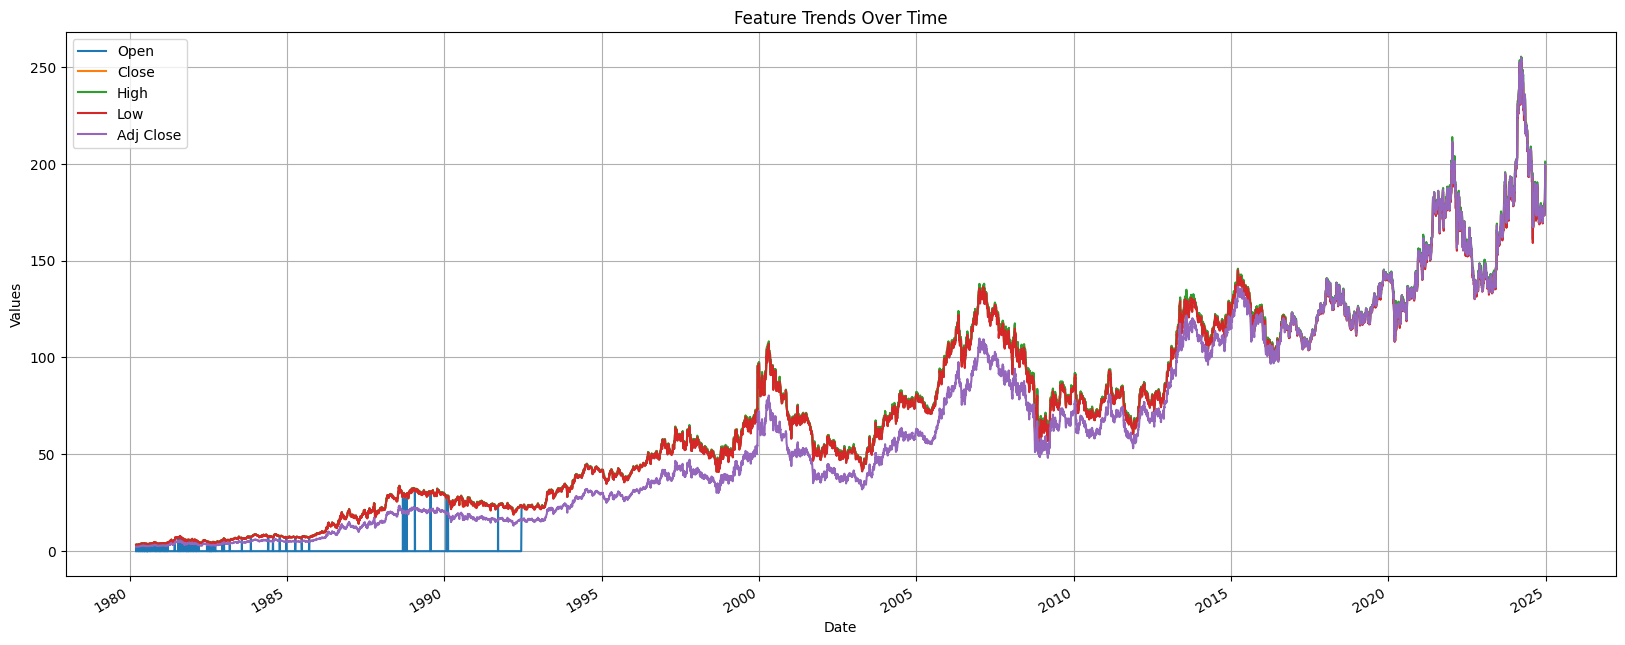

In [39]:
eda = TimeSeriesEDA(df, "Date")
eda.plot_all_features()

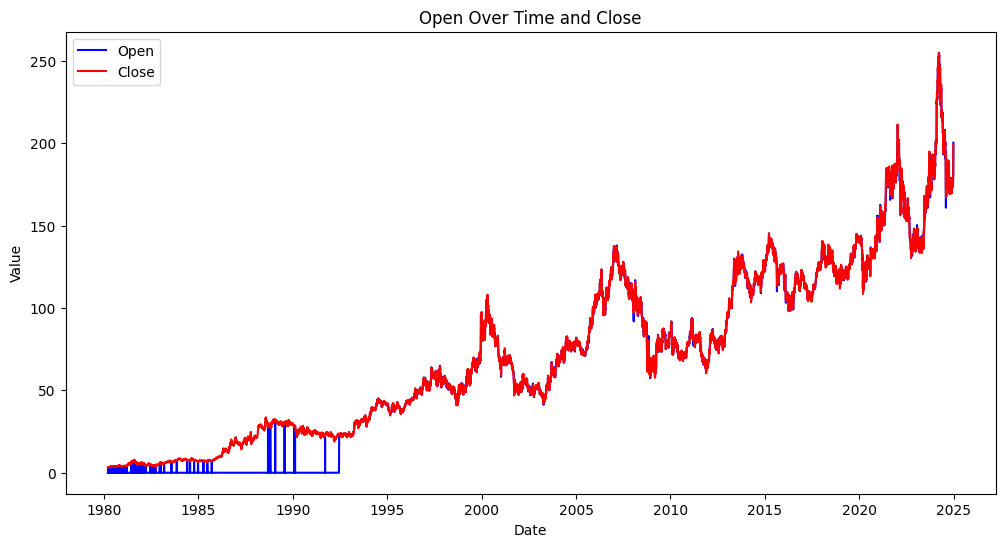

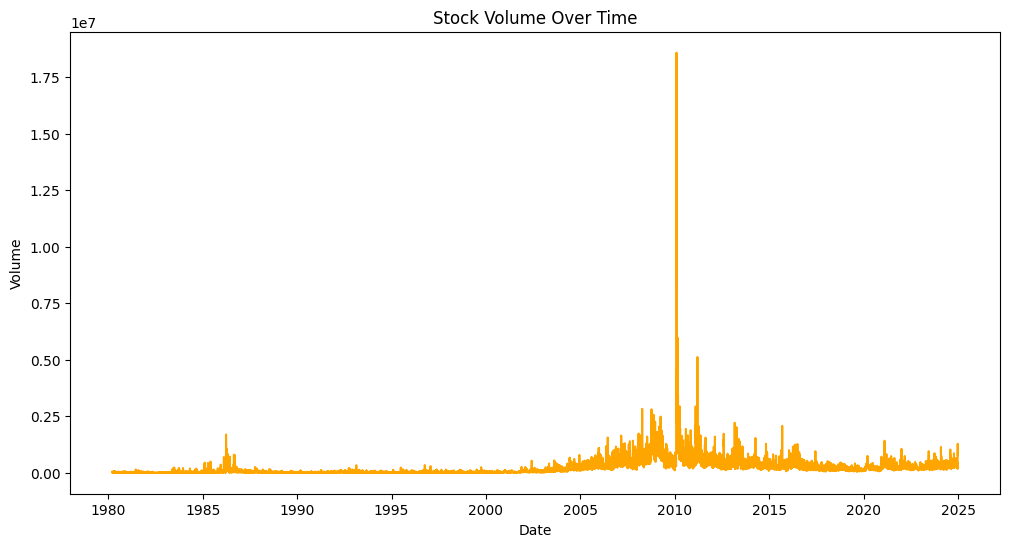

In [7]:
eda.plot_time_series("Open", "Close")
eda.plot_volume("Volume")



   - The graph shows the **Open** and **Close** prices of the stock and **Volume** (number of shares traded) over time..
   

**Key Observations:**
   - The **Open** and **Close** lines are very close to each other, meaning the stock price at the start of the day (Open) and the end of the day (Close) are similar.
   - The stock price was very low in the 1980s (around 0-50) but started increasing after 1990.
   - After 2000, the stock price grew significantly, reaching its highest point around 2020-2025.
   - The **Volume** was very low in the 1980s and 1990s (close to 0).
   - After 2000, the **Volume** started increasing, and it grew significantly after 2010.
   - The highest **Volume** is seen around 2020-2025.

**Insights:**
   - The stock price has grown a lot over time, especially after 2000.
   - The small gap between **Open** and **Close** means the stock price doesn’t change much during the day.
   - More people started trading the stock after 2000, and trading activity increased a lot after 2010.
   - The increase in **Volume** matches the increase in stock price, which means more people were interested in buying and selling the stock as its price went up.

---



### **Close destribution over Year**

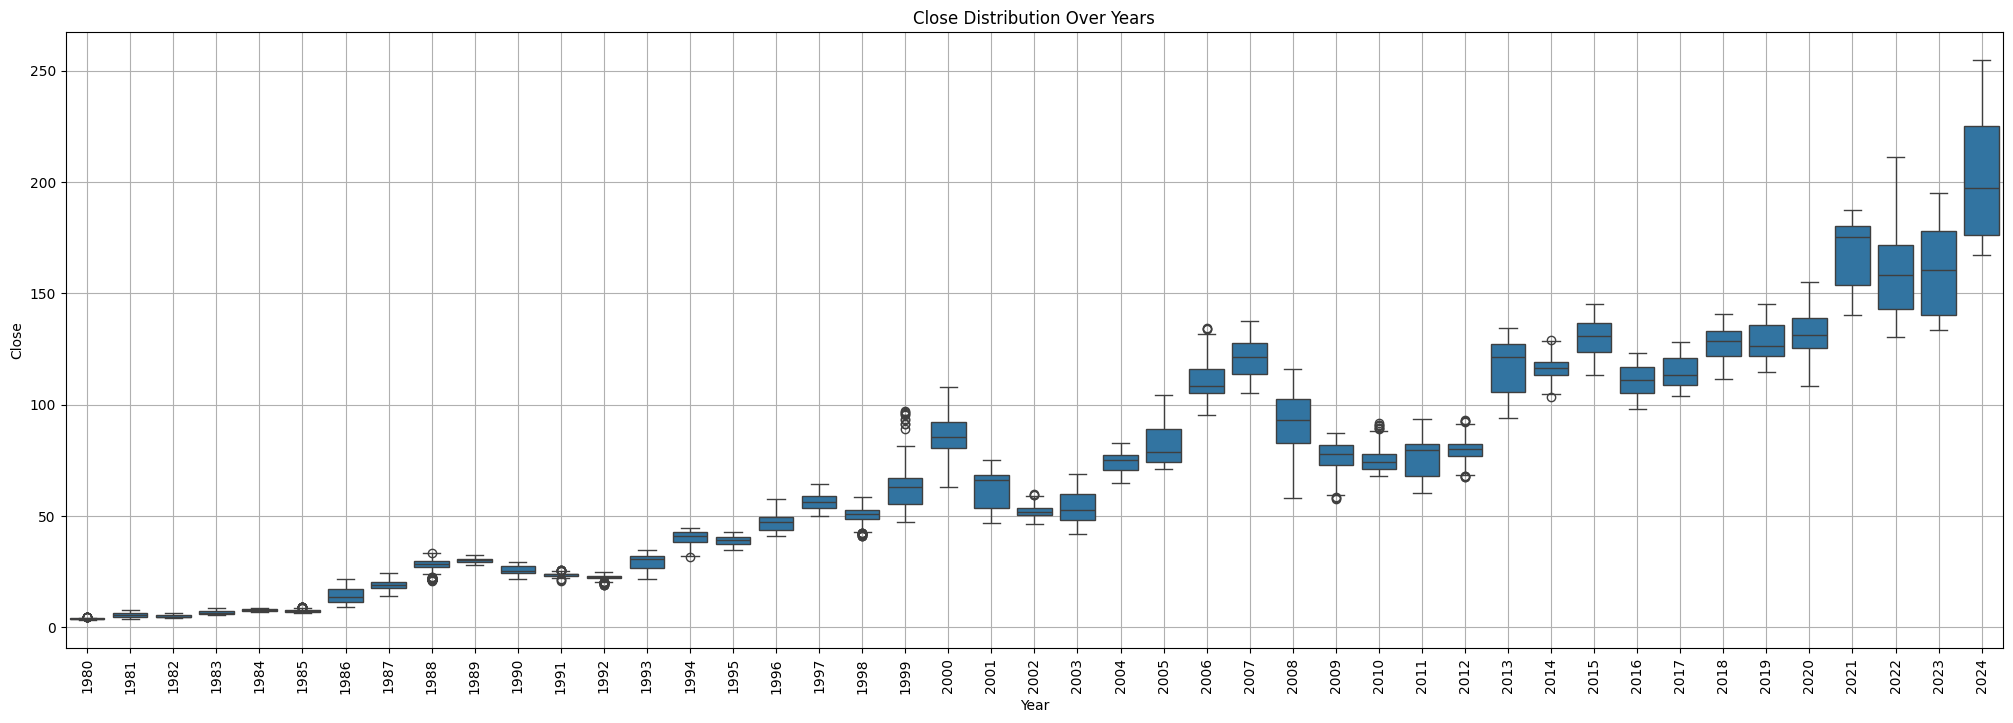

In [8]:
eda.plot_box_by_year("Close")


- This is a boxplot showing the distribution of **closing prices** over different years.  
- **X-axis**: Years (1980 - 2024)  
- **Y-axis**: **Closing prices** of the stock.

**Key Insights**
- **Steady Increase**: The closing prices show a clear upward trend over the decades, indicating long-term stock growth.
- **Higher Volatility in Recent Years**: The spread has widened significantly, especially after 2020, suggesting increased price fluctuations.
- **Market Crashes & Recoveries**:
  - The 2008 **financial crisis** caused a sharp decline in stock prices.
  - A noticeable drop in 2020, followed by a strong recovery.
- **Outliers**: Many years have outliers, especially during market booms and crashes.

**What This Means**
- **Investors** should be aware of periods of high volatility.
- The **median closing price** has been increasing, indicating strong long-term performance.
- The presence of **outliers** suggests moments of extreme highs/lows, possibly due to market corrections or economic events.

---


### **Monthly variation and Monthly trends**

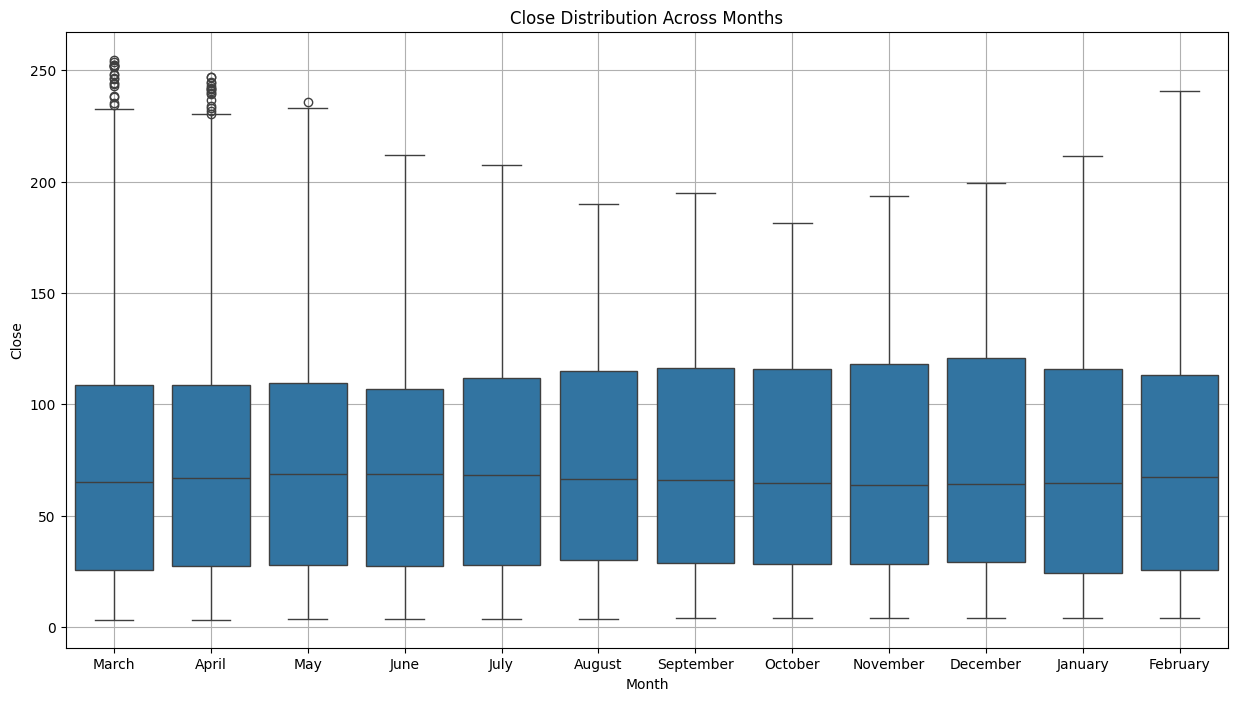

In [9]:
eda.plot_box_by_month("Close")




   - The graph shows the distribution of closing prices (likely the adjusted closing prices) across each month of the year. The x-axis represents the months (from March to February), and the y-axis represents the frequency or count of closing prices within certain ranges.

**Visualizations of key patterns and relationships**:
   - The graph allows us to observe how the closing prices are distributed across different months. It can help identify if certain months tend to have higher or lower closing prices compared to others.
   - The height of the bars indicates the frequency of closing prices within a specific range for each month.

**Analysis of trends, seasonality, and anomalies**:
   - **Trend**: If certain months consistently show higher or lower closing prices, it could indicate a seasonal trend. For example, if December consistently has higher closing prices, it might suggest a year-end rally.
   - **Seasonality**: The graph can help identify seasonal patterns in the stock price. For instance, if the closing prices are consistently higher in certain months (e.g., December) and lower in others (e.g., September), it could indicate seasonality.
   - **Anomalies**: Any month that significantly deviates from the general pattern (e.g., an unusually high or low bar) could indicate an anomaly. For example, if March shows an unusually high frequency of high closing prices, it might be worth investigating further.

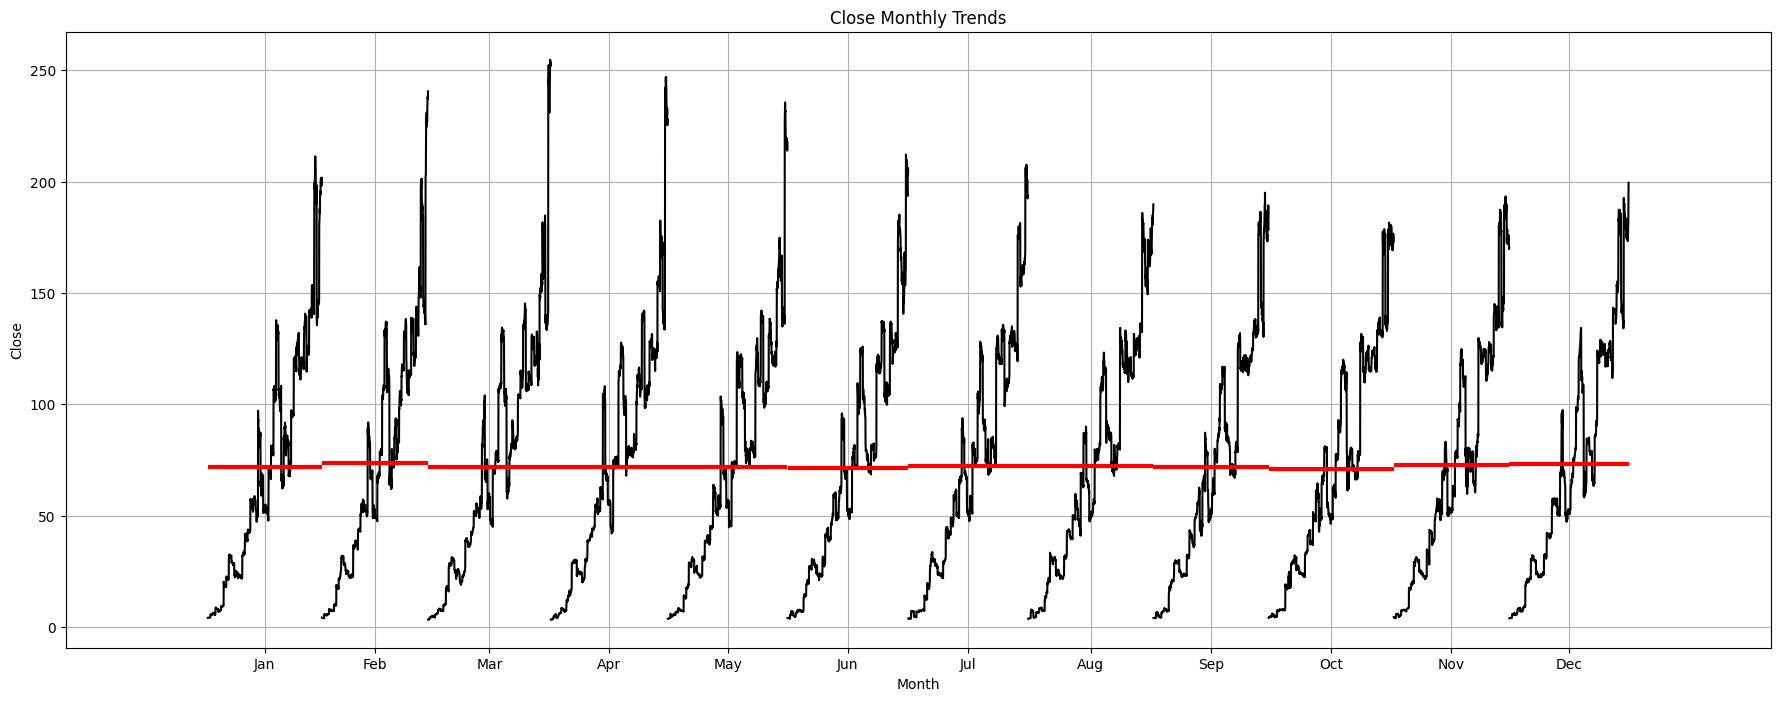

In [10]:
eda.plot_monthly_trends("Close")


- The graph shows the monthly trends of the **"Close"** price of the stock over time.
- The **x-axis** represents the **months** of the year (January to December).
- The **y-axis** represents the **stock price** (Close price).

**Visualizations of Key Patterns and Relationships:**
- The graph shows how the stock's closing price behaves in different months of the year.
- Each line represents a different year, and the lines are grouped by month.

**Analysis of Trends, Seasonality, and Anomalies:**
- **Trends:** The closing price tends to fluctuate throughout the year. Some months show higher prices, while others show lower prices.
- **Seasonality:** There might be some seasonal patterns:
  - The stock price tends to be higher in certain months (e.g., towards the end of the year, like November or December).
  - The price might be lower in other months (e.g., mid-year, like June or July).
- **Anomalies:** Some years show unusual spikes or drops in certain months, which could be due to external factors like market events or news.

---

### **Yearly Average and Quatery Average**

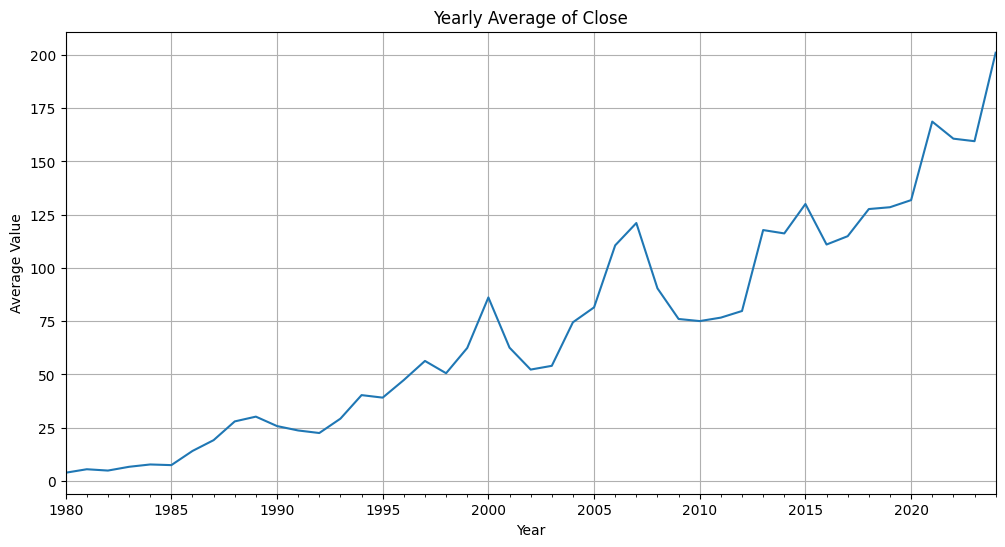

In [11]:
eda.plot_yearly_avg("Close")


   - The graph shows the yearly average of the closing price (likely the adjusted closing price) from 1980 to 2020. The x-axis represents the years, and the y-axis represents the average closing price for each year.

**Visualizations of key patterns and relationships**:
   - The graph allows us to observe the long-term trend of the stock's closing price over several decades. It helps identify whether the stock price has generally increased, decreased, or remained stable over time.
   - The line or bars (depending on the graph type) show the average closing price for each year, allowing us to compare the performance of the stock across different years.

**Analysis of trends, seasonality, and anomalies**:
   - **Trend**: The graph can reveal long-term trends in the stock price. For example, if the average closing price consistently increases over the years, it indicates a bullish trend. Conversely, a consistent decrease would indicate a bearish trend.
   - **Seasonality**: While this graph focuses on yearly averages, it might not directly show seasonality. However, if there are recurring patterns (e.g., certain years consistently show higher or lower averages), it could hint at cyclical behavior.
   - **Anomalies**: Any significant spikes or drops in the average closing price for a particular year could indicate anomalies. For example, if the average closing price in 2008 is significantly lower than surrounding years, it might reflect the impact of the financial crisis.

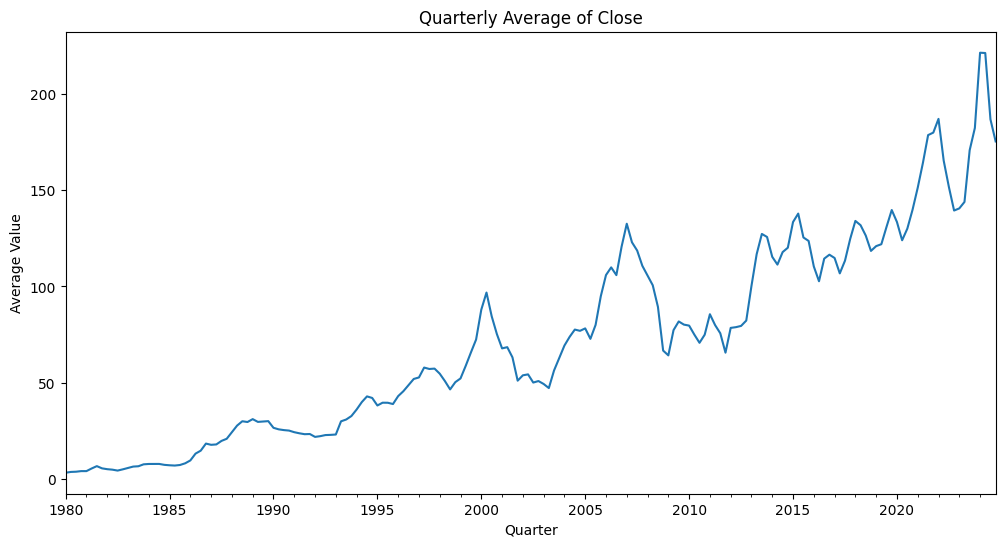

In [12]:
eda.plot_quarterly_avg("Close")


- The graph shows the **quarterly average** of the **"Close"** price of the stock over time.
- The **x-axis** represents the **quarters** (Q1, Q2, Q3, Q4) across different years.
- The **y-axis** represents the **average closing price** of the stock.

**Visualizations of Key Patterns and Relationships:**
- The graph shows how the average closing price of the stock changes over each quarter (3-month period) across multiple years.
- Each point or line represents the average closing price for a specific quarter.

**Analysis of Trends, Seasonality, and Anomalies:**
- **Trends:** The average closing price generally increases over time, especially after the year 2000. This indicates that the stock has grown in value over the long term.
- **Seasonality:** There might be some seasonal patterns within each year:
  - For example, the stock price might be higher in certain quarters (e.g., Q1, Q4) and lower in others (e.g., Q2, Q3).There might be seasonal trends within each year, such as higher prices in begin and end of the year, lower prices in Q2 mid-year.
- **Anomalies:** There are no major anomalies (unusual spikes or drops) in the graph, but the steady increase in price after 2000 is a notable trend.

---

### **Coefficient of variation**

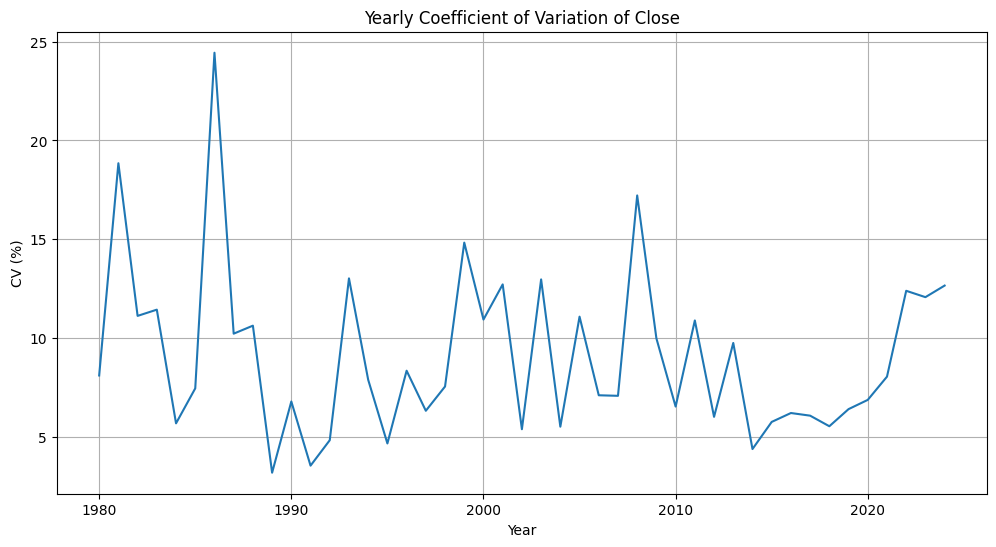

In [13]:
eda.plot_coefficient_of_variation("Close")


   - The graph shows the yearly coefficient of variation (CV) of the closing price (likely the adjusted closing price) from 1980 to 2020. The x-axis represents the years, and the y-axis represents the CV in percentage terms.
   - The CV measures the relative volatility of the stock's closing price for each year. A higher CV indicates greater volatility relative to the mean closing price, while a lower CV indicates more stability.

**Visualizations of key patterns and relationships**:
   - The graph allows us to observe how the volatility of the stock's closing price has changed over time. It helps identify periods of high or low relative volatility.
   - The line or bars (depending on the graph type) show the CV for each year, allowing us to compare the volatility of the stock across different years.

**Analysis of trends, seasonality, and anomalies**:
   - **Trend**: The graph can reveal trends in the stock's volatility over time. For example, if the CV consistently increases over the years, it indicates that the stock has become more volatile relative to its mean price. Conversely, a decreasing trend would indicate that the stock has become more stable.
   - **Seasonality**: While this graph focuses on yearly CV, it might not directly show seasonality. However, if there are recurring patterns (e.g., certain years consistently show higher or lower CV), it could hint at cyclical behavior in volatility.
   - **Anomalies**: Any significant spikes or drops in the CV for a particular year could indicate anomalies. For example, if the CV in 2008 is significantly higher than surrounding years, it might reflect the impact of the financial crisis, which caused extreme market volatility.

---

### **Top Months by Volatility**

In [34]:
eda.plot_top_months_by_volatility(10)


The graph titled **"Top 10 Months by Standard Deviation of Price Change Within a Day"** visualizes the **top 10 months** with the highest **volatility** in daily price changes. Volatility is measured by the **standard deviation** of the daily price differences (`price_diff = Close - Open`). Each marker represents a month, and its size and color correspond to the standard deviation of the daily price changes during that month.

- **X-axis**: Represents time (from 1980 to 2010).
- **Y-axis**: Represents the standard deviation of the daily price differences (`price_diff`).
- **Marker Size and Color**: Represent the magnitude of the standard deviation (larger and darker markers indicate higher volatility).




**Key Insights from Visualization**
1. **High Volatility Months**:
   - The graph highlights the **top 10 months** with the highest volatility in daily price changes. These months are likely associated with significant market events or economic crises.

2. **Temporal Distribution**:
   - The high-volatility months are not evenly distributed over time. They tend to cluster around specific periods, such as the early 1980s, late 1990s, and late 2000s.

3. **Magnitude of Volatility**:
   - The standard deviation values range from **2 to 14**, with the highest values occurring in the late 1990s and early 2000s. This indicates extreme price movements during those months.

4. **Anomalies**:
   - The months with the highest volatility likely correspond to major market events, such as the **Dot-com Bubble (late 1990s)** and the **2008 Financial Crisis**.



**Analysis of Trends, Seasonality, and Anomalies**
1. **Trends**:
   - The graph does not show a clear long-term trend in volatility. Instead, it highlights **sporadic spikes** in volatility during specific months.
   - The highest volatility months are concentrated in the late 1990s and early 2000s, suggesting that these periods were particularly turbulent for the stock.

2. **Seasonality**:
   - There is no evidence of **seasonality** in the graph. The high-volatility months do not follow a regular pattern (e.g., occurring in specific months or quarters).

3. **Anomalies**:
   - **Late 1990s and Early 2000s**: The months with the highest volatility likely correspond to the **Dot-com Bubble** and its subsequent burst, which caused extreme price movements in technology and growth stocks.
   - **2008**: The high volatility in 2008 is likely associated with the **2008 Financial Crisis**, which led to widespread market instability.

---

### **Rolling Statistics and Stationary**

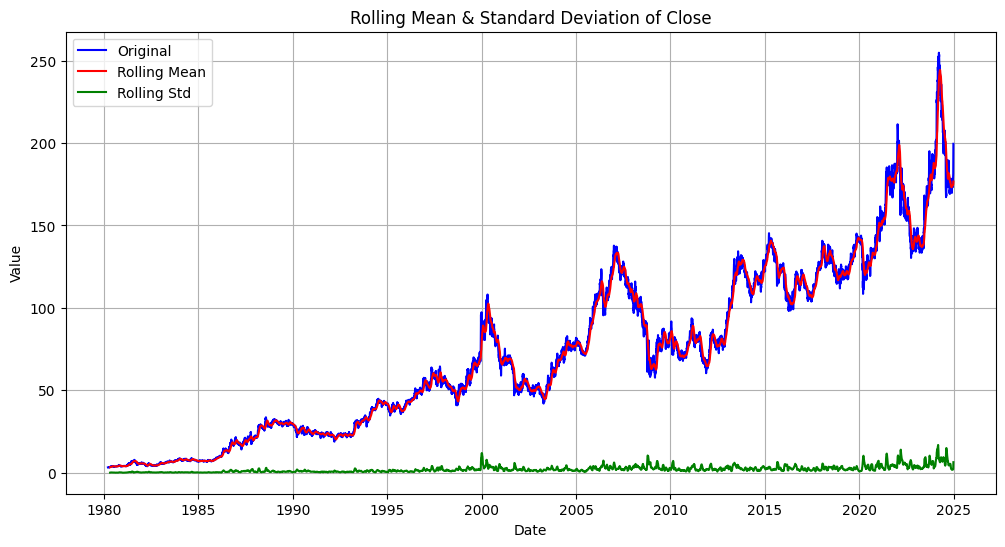

In [14]:
eda.plot_rolling_statistics("Close")


   - The graph shows three lines:
     - **Original**: The actual closing price over time.
     - **Rolling Mean**: The rolling average (mean) of the closing price over a specified window (30 days). This smooths out short-term fluctuations and highlights long-term trends.
     - **Rolling Standard Deviation**: The rolling standard deviation of the closing price over the same window. This measures the volatility of the stock price over time.
   - The x-axis represents the date (from 1980 to 2025), and the y-axis represents the value of the closing price, rolling mean, and rolling standard deviation.

**Visualizations of key patterns and relationships**:
   - The **rolling mean** helps identify the long-term trend of the stock price by smoothing out short-term noise. It shows whether the stock price is generally increasing, decreasing, or remaining stable over time.
   - The **rolling standard deviation** helps identify periods of high or low volatility. When the standard deviation is high, it indicates that the stock price is fluctuating significantly, and when it is low, the stock price is more stable.
   - The **original closing price** provides context for the rolling mean and standard deviation, showing the actual price movements.

**Analysis of trends, seasonality, and anomalies**:
   - **Trend**: The rolling mean line helps identify the long-term trend of the stock price. For example, if the rolling mean consistently increases over time, it indicates a bullish trend. Conversely, a decreasing rolling mean indicates a bearish trend.
   - **Volatility**: The rolling standard deviation line helps identify periods of high or low volatility. For example, during market crashes or periods of economic instability, the rolling standard deviation may spike, indicating increased volatility.
   - **Anomalies**: Any significant deviations between the original closing price and the rolling mean could indicate anomalies. For example, if the original price spikes far above the rolling mean, it might indicate a short-term price surge or an outlier event.



In [15]:
eda.perform_adf_test("Close")

ADF Statistic: -0.46737151245213665
p-value: 0.8982279985700212
Critical Values: {'1%': np.float64(-3.4309306294476727), '5%': np.float64(-2.8617966068504166), '10%': np.float64(-2.5669065867160596)}
Fail to reject the null hypothesis: Data is non-stationary.


##### **Insights from the ADF Test Results**

**What the test represents**:
   - The ADF test checks whether a time series is stationary or non-stationary. The null hypothesis (\(H_0\)) is that the data is non-stationary (has a unit root), while the alternative hypothesis (\(H_1\)) is that the data is stationary.

**Key metrics from the test**:
   - **ADF Statistic**: -0.46737151245213665
   - **p-value**: 0.8982279985700212
   - **Critical Values**:
     - 1%: -3.430
     - 5%: -2.861
     - 10%: -2.566

**Interpretation of the results**:
   - The **p-value (0.898)** is much greater than 0.05, so we **fail to reject the null hypothesis**. This means the data is **non-stationary**.
   - The **ADF statistic (-0.467)** is also less negative than all critical values, further supporting the conclusion that the data is non-stationary.

**Implications for modeling**:
   - Non-stationary data can be challenging to model because its statistical properties (mean, variance, etc.) change over time. This can lead to unreliable predictions.
   - To make the data stationary, you may need to apply transformations such as:
     - **Differencing**: Subtract the previous value from the current value to remove trends.
     - **Log transformation**: Apply a logarithmic transformation to stabilize variance.
     - **Detrending**: Remove trends or seasonality from the data.

---

### **Decomposition Analysis**

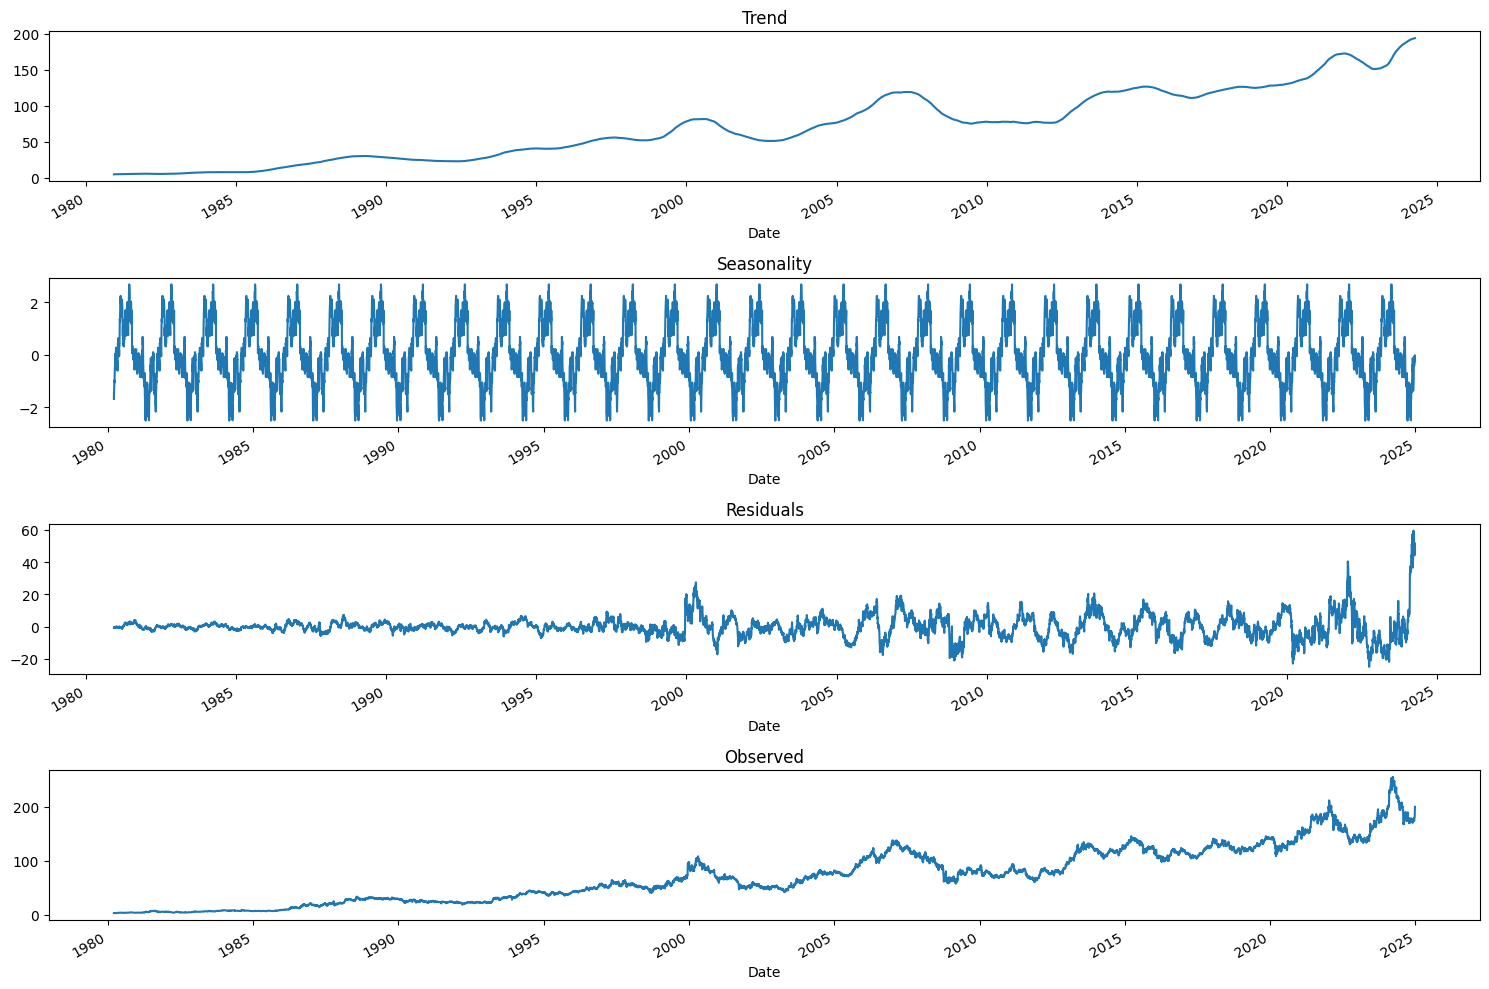

In [16]:
eda.plot_decomposition("Close")



##### **1. Trend Component**  
**Representation**  
- This graph represents the **long-term movement** of the closing price.
- It captures **gradual increases or decreases** over time by filtering out short-term fluctuations.

**Key Patterns & Relationships**  
- A **general upward trend** is observed, indicating **long-term growth**.
- Periods of **stagnation or decline** may represent **market corrections, financial crises, or company-specific downturns**.

**Analysis**  
- A **consistent rise** in stock price suggests the company is **growing and gaining value**.
- The **dips and plateaus** could be linked to **economic recessions, policy changes, or investor sentiment shifts**.
- The **most recent period** shows a **sharp increase**, which might be due to **market optimism, high earnings, or external economic factors**.



##### **2. Seasonality Component**  
**Representation**  
- This graph represents **repeating patterns** that occur at regular intervals (e.g., daily, monthly, yearly).
- It highlights **predictable cycles** in stock price movements.

**Key Patterns & Relationships**  
- The pattern suggests **recurring fluctuations**, meaning stock prices tend to **rise and fall in a consistent cycle**.
- The **frequency** of the peaks and troughs suggests a **strong seasonal component**.

**Analysis**  
- Seasonality could be due to **quarterly earnings reports, market cycles, or investor behavior**.
- Some industries (like retail) experience **higher prices in specific months** (e.g., holiday season).
- Understanding this pattern helps in **making better investment decisions**, like identifying the best times to buy/sell.



##### **3. Residuals Component**  
**Representation**  
- Residuals represent the **unexplained variations** in the data after removing trend and seasonality.
- It shows **random noise and anomalies** that are not part of the regular patterns.

**Key Patterns & Relationships**  
- **Mostly stable** throughout, meaning the model captures most of the patterns.
- Some **periods of higher residual values** suggest **unexpected volatility**.
- Towards the **end of the graph**, residuals increase significantly, indicating **sudden market events or outliers**.

**Analysis**  
- Residuals should ideally be **randomly distributed**; any visible patterns might indicate **missing factors in the model**.
- Large residuals could be caused by **unexpected market events** (e.g., economic crashes, sudden policy changes).
- **Increased volatility at the end** may suggest **recent market instability** or **external shocks**.



##### **4. Observed Component**  
**Representation**  
- This is the **original stock price data** before decomposition.
- It represents the actual closing price with all trends, seasonality, and noise included.

**Key Patterns & Relationships**  
- The price shows **significant growth over time**.
- Some **sharp peaks and dips** suggest **high volatility in certain periods**.
- The **most recent years** display an **increasing trend with stronger fluctuations**.

**Analysis**  
- The overall trend suggests that the stock has been **growing in value**.
- Spikes and drops could be linked to **external market events (e.g., financial crises, corporate news, economic policies)**.
- **Understanding these components helps in forecasting** future stock prices by identifying key influencing factors.


---

### **Partial and Auto Correlation**

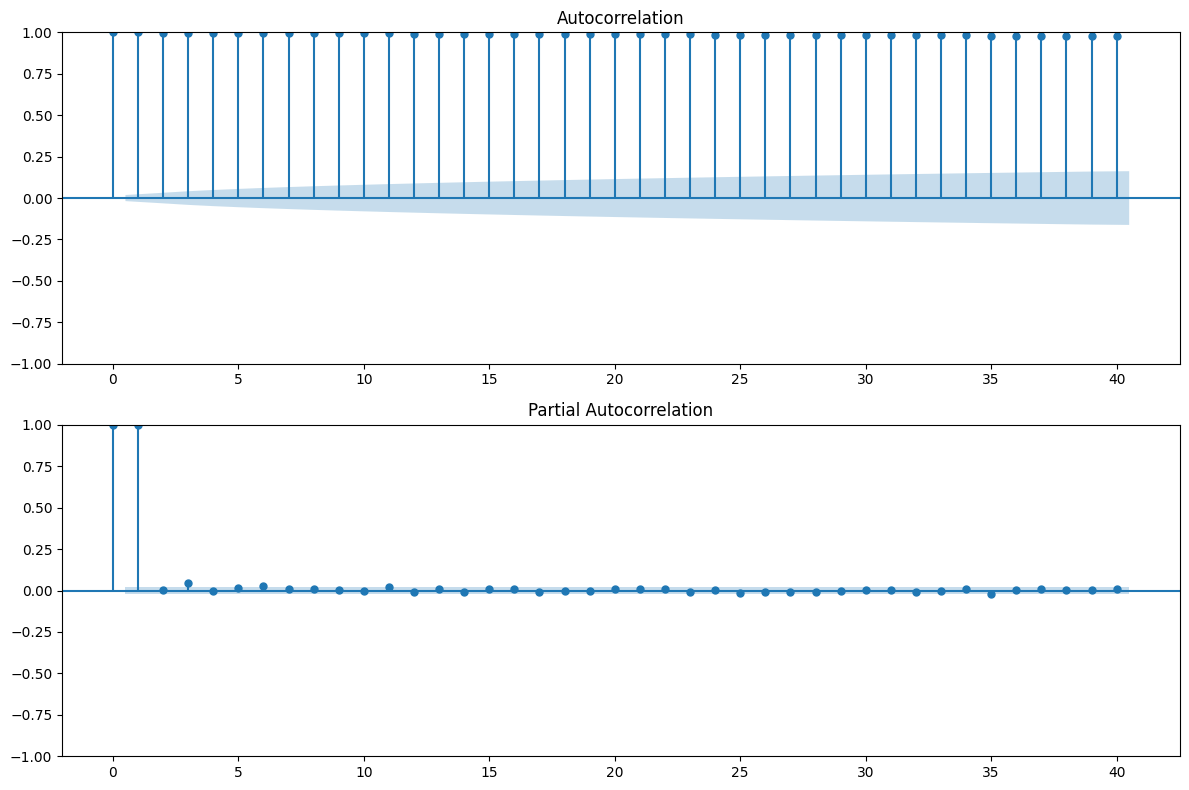

In [17]:
eda.plot_acf_pacf("Close")


- **Autocorrelation (ACF):** This graph shows how correlated the stock's closing price is with its past values at different time lags (e.g., 1 day ago, 2 days ago, etc.).
- **Partial Autocorrelation (PACF):** This graph shows the correlation between the stock's closing price and its past values, but after removing the influence of other time lags.

**Visualizations of Key Patterns and Relationships:**
- **Autocorrelation (ACF):**
  - The **x-axis** represents the **time lags** (e.g., 0 to 40 days).
  - The **y-axis** represents the **correlation coefficient** (ranging from -1 to 1).
  - The blue shaded region represents the **confidence interval**. If the bars go outside this region, the correlation is statistically significant.
- **Partial Autocorrelation (PACF):**
  - The **x-axis** represents the **time lags** (e.g., 0 to 40 days).
  - The **y-axis** represents the **partial correlation coefficient** (ranging from -1 to 1).
  - The blue shaded region represents the **confidence interval**. If the bars go outside this region, the correlation is statistically significant.

**Analysis of Trends, Seasonality, and Anomalies:**
- **Autocorrelation (ACF):**
  - The stock's closing price is highly correlated with its recent past values (e.g., 1-2 days ago).
  - The correlation decreases as the lag increases, which is typical for time series data.
  - There might be some **seasonal patterns** (e.g., spikes at regular intervals like 7, 14, 21 days), indicating weekly seasonality.
- **Partial Autocorrelation (PACF):**
  - The stock's closing price is strongly correlated with its immediate past values (e.g., 1-2 days ago).
  - After a few lags, the correlation drops sharply, indicating that the influence of older data points diminishes quickly.
  - This suggests that the stock price is influenced more by recent events than by older ones.

---

### **Quantile Trends**

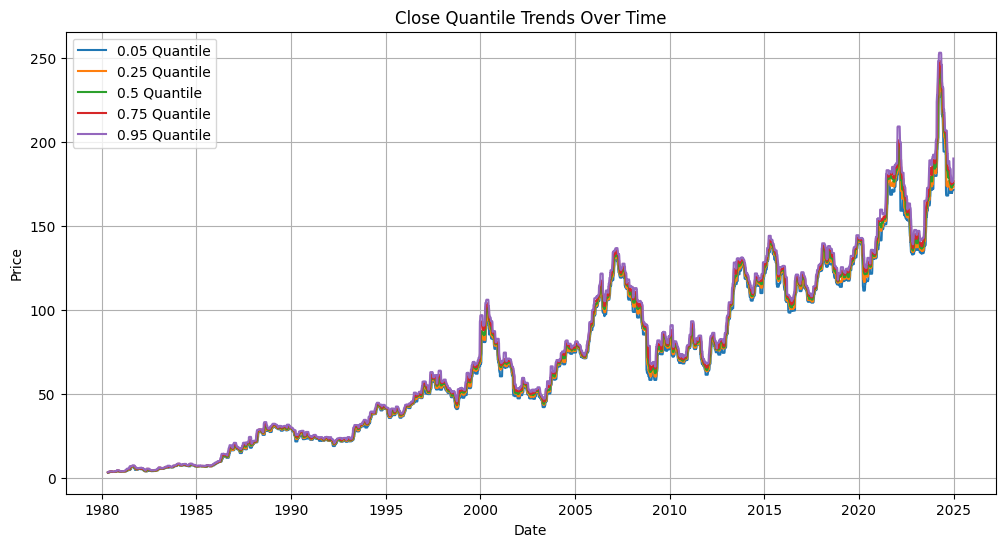

In [18]:
eda.plot_quantile_trends("Close")


The graph titled **"Close Quantile Trends Over Time"** visualizes the trends of different quantiles (0.05, 0.25, 0.5, 0.75, 0.95) of the **closing price** of a stock over time. Each quantile represents a specific percentile of the closing price distribution:
- **0.05 Quantile**: The 5th percentile (lower range of prices).
- **0.25 Quantile**: The 25th percentile (lower-middle range of prices).
- **0.5 Quantile**: The 50th percentile (median price).
- **0.75 Quantile**: The 75th percentile (upper-middle range of prices).
- **0.95 Quantile**: The 95th percentile (upper range of prices).

The x-axis represents **time** (from 1980 to 2025), and the y-axis represents the **closing price** of the stock.



**Key Insights from Visualization**
1. **Long-Term Growth Trend**:
   - The **0.5 Quantile (Median)** and **0.95 Quantile (Upper Range)** show a clear upward trend over time, indicating that the stock's closing price has generally increased over the years.
   - The **0.05 Quantile (Lower Range)** also shows growth but at a slower pace, suggesting that even the lowest prices have increased over time.

2. **Volatility Over Time**:
   - The gap between the **0.05 Quantile** and **0.95 Quantile** represents the volatility in the stock's closing price. This gap widens over time, indicating increasing volatility in the stock's price movements.

3. **Seasonality**:
   - The graph does not show strong seasonal patterns, as the quantile trends are relatively smooth without recurring spikes or dips at regular intervals.

4. **Anomalies**:
   - There are occasional sharp drops or spikes in the quantile trends, which could represent market anomalies or significant events (e.g., financial crises, market crashes, or sudden price surges).

5. **Convergence and Divergence**:
   - In some periods, the quantiles converge (e.g., around 1990 and 2010), indicating lower volatility. In other periods, they diverge (e.g., around 2000 and 2020), indicating higher volatility.



**Analysis of Trends, Seasonality, and Anomalies**
1. **Trends**:
   - The overall trend is **upward**, with the median and upper quantiles showing consistent growth. This suggests that the stock has been a good long-term investment.
   - The lower quantile (0.05) also shows growth but at a slower rate, indicating that even during downturns, the stock's price has not fallen drastically.

2. **Seasonality**:
   - There is no clear evidence of **seasonality** in the graph. The trends are relatively smooth, and there are no recurring patterns that repeat at regular intervals (e.g., yearly or quarterly).

3. **Anomalies**:
   - **Sharp Drops**: There are noticeable drops in the quantile trends around **2000** and **2008**, which could correspond to market crashes (e.g., the Dot-com Bubble and the 2008 Financial Crisis).
   - **Sharp Spikes**: There are spikes in the upper quantiles (e.g., around 2020), which could represent periods of rapid price appreciation or market bubbles.

---

### **Price Difference Standard Deviation**

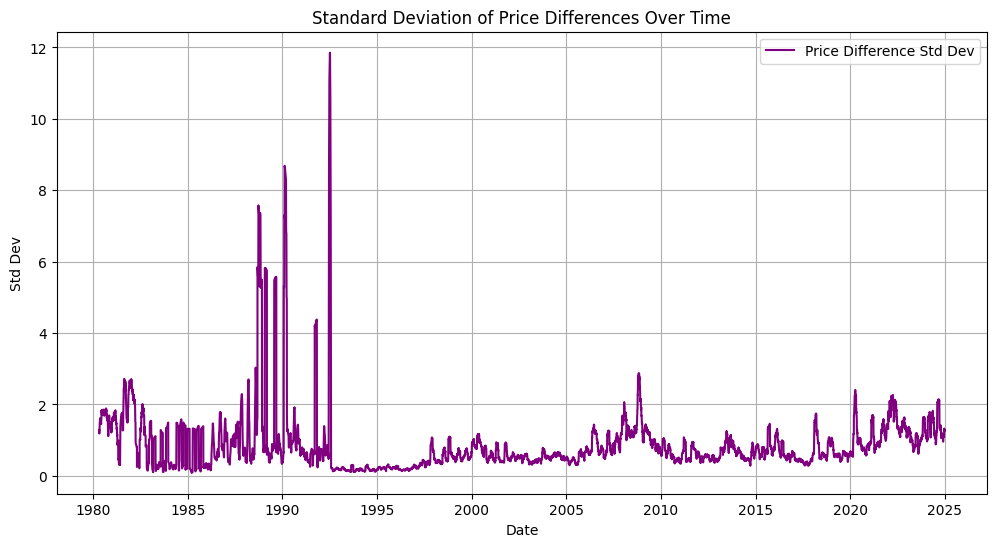

In [19]:
eda.plot_price_diff_std()

**What Does the Graph Represent?**
The graph titled **"Standard Deviation of Price Differences Over Time"** visualizes the **volatility** of the daily price differences between the **closing price** and the **opening price** of a stock over time. The standard deviation (`Std Dev`) is calculated over a rolling window of 30 days, which smooths out short-term fluctuations and highlights longer-term trends in volatility.

- **X-axis**: Represents time (from 1980 to 2025).
- **Y-axis**: Represents the standard deviation of the daily price differences (`price_diff`).



**Key Insights from Visualization**
1. **Volatility Trends**:
   - The graph shows periods of **high volatility** (peaks) and **low volatility** (troughs) over time.
   - Volatility tends to increase during periods of market uncertainty or economic crises (e.g., around 2000 and 2008).

2. **Long-Term Volatility**:
   - The overall trend in volatility appears to be **increasing** over time, especially after 2000. This suggests that the stock's price movements have become more unpredictable in recent years.

3. **Seasonality**:
   - There is no clear evidence of **seasonality** in the graph. The volatility trends do not show recurring patterns at regular intervals (e.g., yearly or quarterly).

4. **Anomalies**:
   - **Sharp Peaks**: There are noticeable spikes in volatility around **2000** and **2008**, which likely correspond to major market events (e.g., the Dot-com Bubble and the 2008 Financial Crisis).
   - **Recent Volatility**: The graph shows increased volatility in recent years (e.g., around 2020), possibly due to events like the COVID-19 pandemic.



**Analysis of Trends, Seasonality, and Anomalies**
1. **Trends**:
   - The graph indicates an **upward trend in volatility** over time, especially after 2000. This suggests that the stock's price movements have become more erratic in recent decades.
   - The rolling standard deviation helps smooth out short-term fluctuations, making it easier to identify long-term trends.

2. **Seasonality**:
   - There is no clear **seasonal pattern** in the graph. Volatility does not appear to follow a regular cycle (e.g., higher volatility in certain months or quarters).

3. **Anomalies**:
   - **2000 and 2008 Peaks**: The sharp spikes in volatility around these years correspond to major financial crises, indicating that the stock was highly sensitive to market conditions during these periods.
   - **2020 Volatility**: The increase in volatility around 2020 likely reflects the impact of the COVID-19 pandemic on the stock market.

---

### **Cumulative Returns by Quantiles**

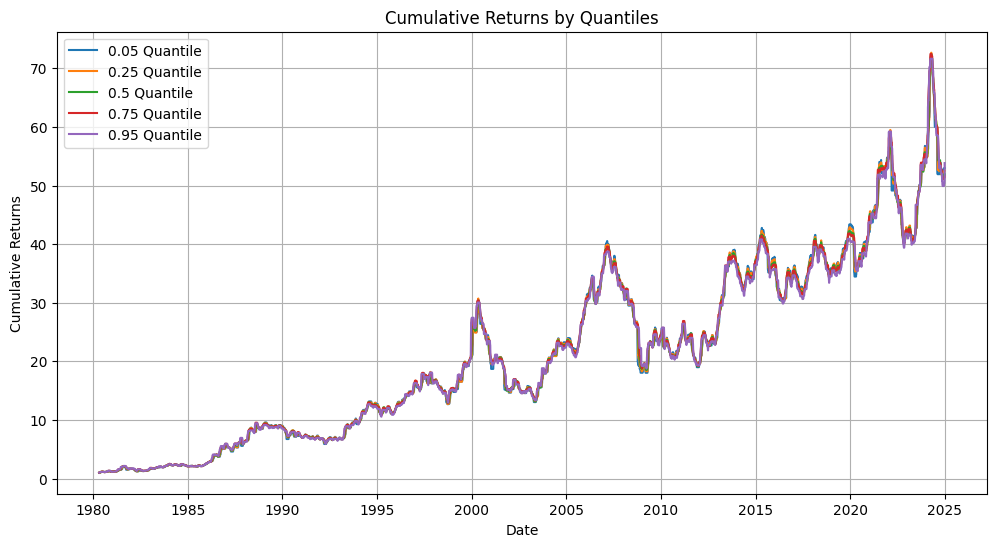

In [20]:
eda.plot_cumulative_returns_by_quantiles("Close")


The graph titled **"Cumulative Returns by Quantiles"** visualizes the **cumulative returns** of the **closing price** for different quantiles (0.05, 0.25, 0.5, 0.75, 0.95) over time. Cumulative returns show the total growth of an investment over a period, starting from a base value.

- **X-axis**: Represents time (from 1980 to 2025).
- **Y-axis**: Represents the **cumulative returns** (total growth over time).
- **Quantiles**: Each line represents a specific quantile of the closing price distribution.


**Key Insights from Visualization**
1. **Growth Trends**:
   - The **0.5 Quantile (Median)** and **0.95 Quantile (Upper Range)** show strong **upward trends**, indicating significant long-term growth.
   - The **0.05 Quantile (Lower Range)** also grows but at a slower pace, suggesting that even the lowest returns have increased over time.

2. **Volatility**:
   - The gap between the **0.05 Quantile** and **0.95 Quantile** represents the **volatility** in returns. A wider gap indicates higher volatility.

3. **Anomalies**:
   - Sharp drops or spikes in cumulative returns (e.g., around 2000 and 2008) correspond to **market anomalies** like the Dot-com Bubble and the 2008 Financial Crisis.



**Analysis of Trends, Seasonality, and Anomalies**
1. **Trends**:
   - The overall trend is **upward**, with the median and upper quantiles showing consistent growth.
   - The lower quantile also grows but at a slower rate, indicating resilience even during downturns.

2. **Seasonality**:
   - No clear **seasonality** is observed; the trends are smooth without recurring patterns.

3. **Anomalies**:
   - **2000 and 2008**: Sharp drops correspond to market crashes.
   - **2020**: Increased volatility likely due to the COVID-19 pandemic.

---

### **Top N Months by Volatility**

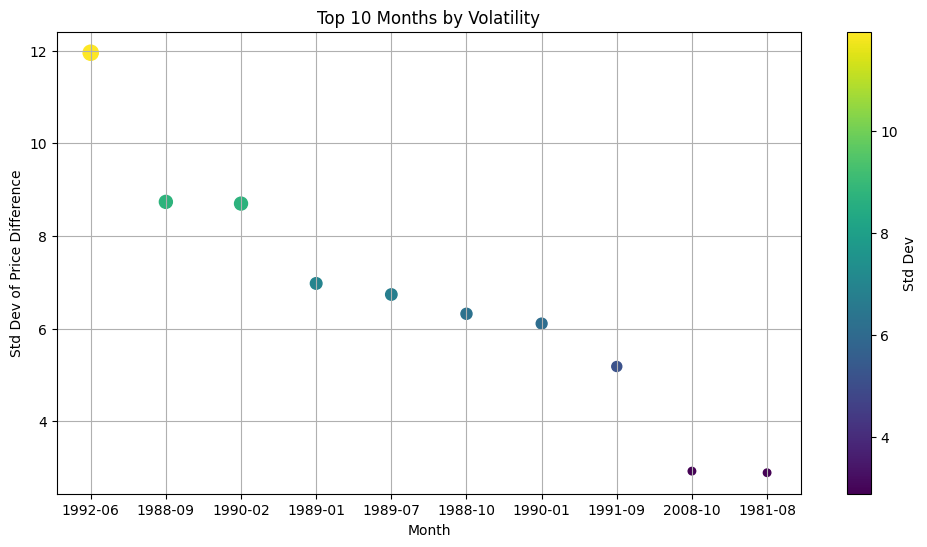

In [21]:
eda.plot_top_n_months_by_volatility("Close")


The graph titled **"Top 10 Months by Volatility"** visualizes the **top 10 months** with the highest **volatility** in daily price changes. Volatility is measured by the **standard deviation** of the daily price differences (`price_diff = Close - Open`). Each marker represents a month, and its size and color correspond to the standard deviation of the daily price changes during that month.

- **X-axis**: Represents the **month** (e.g., 1992-06, 1988-09, etc.).
- **Y-axis**: Represents the **standard deviation** of the daily price differences (`price_diff`).
- **Marker Size and Color**: Represent the magnitude of the standard deviation (larger and darker markers indicate higher volatility).



**Key Insights from Visualization**
1. **High Volatility Months**:
   - The graph highlights the **top 10 months** with the highest volatility in daily price changes. These months are likely associated with significant market events or economic crises.

2. **Temporal Distribution**:
   - The high-volatility months are spread across different years, with clusters in the late 1980s, early 1990s, and 2008. This suggests that volatility spikes are not confined to a single period but occur sporadically.

3. **Magnitude of Volatility**:
   - The standard deviation values vary significantly, with the highest values occurring in **1992-06** and **2008-10**. These months likely experienced extreme price movements.

4. **Anomalies**:
   - The months with the highest volatility likely correspond to major market events, such as the **1990-1991 recession** and the **2008 Financial Crisis**.



**Analysis of Trends, Seasonality, and Anomalies**
1. **Trends**:
   - The graph does not show a clear long-term trend in volatility. Instead, it highlights **sporadic spikes** in volatility during specific months.
   - The highest volatility months are concentrated in the late 1980s, early 1990s, and 2008, suggesting that these periods were particularly turbulent for the stock.

2. **Seasonality**:
   - There is no evidence of **seasonality** in the graph. The high-volatility months do not follow a regular pattern (e.g., occurring in specific months or quarters).

3. **Anomalies**:
   - **1992-06**: This month stands out with the highest volatility, possibly due to market uncertainty or a specific event during that period.
   - **2008-10**: The high volatility in this month is likely associated with the **2008 Financial Crisis**, which led to widespread market instability.
   - **Late 1980s and Early 1990s**: The high volatility in these months may correspond to economic recessions or market corrections during that period.


---

### **Rolling Quantile Analysis**

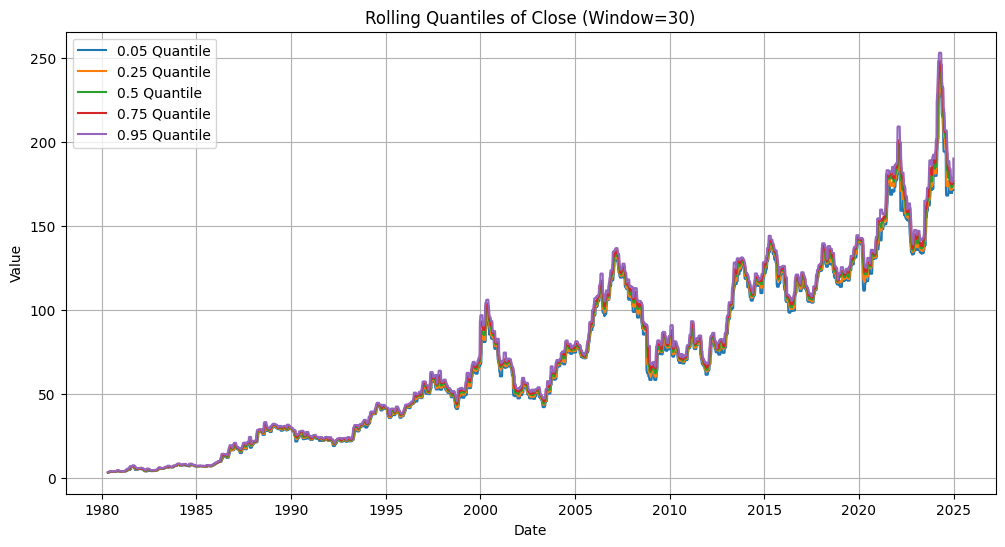

In [22]:
eda.plot_rolling_quantiles("Close")


The graph titled **"Rolling Quantiles of Close (Window=30)"** visualizes the **rolling quantiles** (0.05, 0.25, 0.5, 0.75, 0.95) of the **closing price** of a stock over time. These quantiles are calculated over a rolling window of 30 days, showing the distribution of closing prices and how it changes over time.

- **X-axis**: Represents time (from 1980 to 2025).
- **Y-axis**: Represents the **closing price** values.
- **Quantiles**: Each line represents a specific quantile of the closing price distribution over the rolling window.



**Key Insights from Visualization**
1. **Price Distribution**:
   - The **0.5 Quantile (Median)** shows the central tendency of the closing price, while the other quantiles show the spread (volatility).
   - The gap between the **0.05 Quantile** and **0.95 Quantile** represents the range of price movements, indicating volatility.

2. **Volatility Trends**:
   - The widening gap between quantiles over time suggests **increasing volatility** in the stock's price.
   - Periods with large gaps (e.g., around 2000 and 2008) correspond to high market volatility.

3. **Anomalies**:
   - Sharp divergences in quantiles (e.g., around 2000 and 2008) indicate **market anomalies** or crises, such as the Dot-com Bubble and the 2008 Financial Crisis.



**Analysis of Trends, Seasonality, and Anomalies**
1. **Trends**:
   - The **0.5 Quantile (Median)** shows a clear **upward trend**, indicating long-term price growth.
   - The widening gap between quantiles suggests **increasing volatility** over time.

2. **Seasonality**:
   - No clear **seasonality** is observed; the quantile trends do not show recurring patterns at regular intervals.

3. **Anomalies**:
   - **2000 and 2008**: Sharp divergences in quantiles correspond to market crises.
   - **2020**: Increased volatility likely due to the COVID-19 pandemic.


---

### **Rolling Correlation**

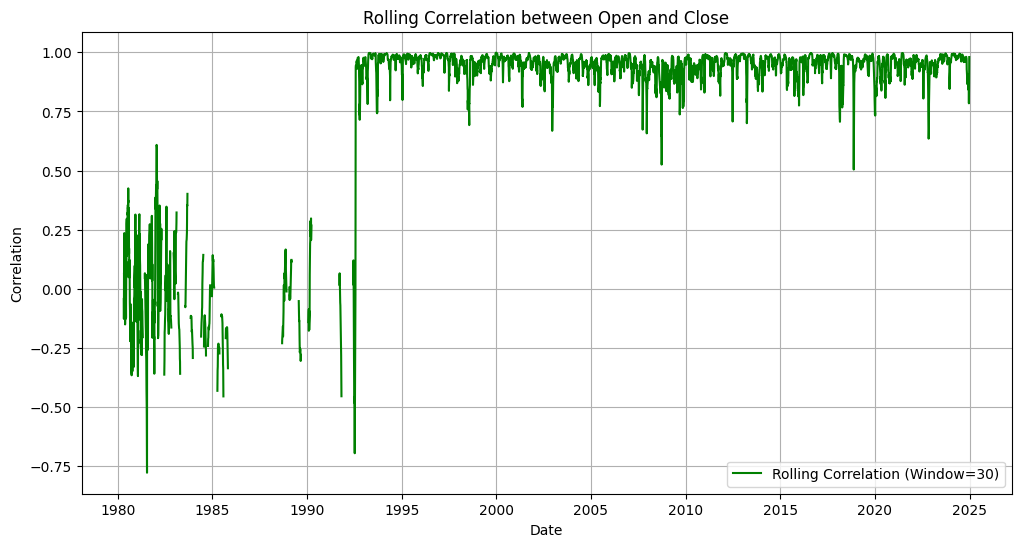

In [26]:
eda.plot_rolling_correlation("Open", "Close")


The graph titled **"Rolling Correlation between Open and Close"** visualizes the **rolling correlation** between the **opening price** and the **closing price** of a stock over time. The correlation is calculated over a rolling window of 30 days, which smooths out short-term fluctuations and highlights longer-term trends in the relationship between the two prices.

- **X-axis**: Represents time (from 1980 to 2025).
- **Y-axis**: Represents the **correlation coefficient** between the opening and closing prices.
  - A correlation of **1** indicates a perfect positive relationship.
  - A correlation of **-1** indicates a perfect negative relationship.
  - A correlation of **0** indicates no relationship.



**Key Insights from Visualization**
1. **Correlation Trends**:
   - The rolling correlation between the opening and closing prices is generally **positive**, indicating that the closing price tends to move in the same direction as the opening price.
   - The correlation fluctuates over time, with periods of **strong positive correlation** (close to 1) and periods of **weaker correlation** (closer to 0).

2. **Volatility in Correlation**:
   - The correlation is not constant and shows significant fluctuations, especially in the early 1980s and around 2008. This suggests that the relationship between the opening and closing prices can vary depending on market conditions.

3. **Anomalies**:
   - There are occasional dips in the correlation, where the relationship between the opening and closing prices weakens or becomes slightly negative. These dips may correspond to periods of market uncertainty or anomalies.

4. **Recent Trends**:
   - In recent years (e.g., after 2010), the correlation appears to stabilize around **0.75**, indicating a consistently strong positive relationship between the opening and closing prices.



**Analysis of Trends, Seasonality, and Anomalies**
1. **Trends**:
   - The overall trend in the rolling correlation is **positive**, with the correlation coefficient generally staying above **0.5**. This suggests that the opening and closing prices tend to move together over time.
   - The correlation has become more stable in recent years, indicating a stronger and more consistent relationship between the two prices.

2. **Seasonality**:
   - There is no clear evidence of **seasonality** in the graph. The correlation does not show recurring patterns at regular intervals (e.g., yearly or quarterly).

3. **Anomalies**:
   - **Early 1980s**: The correlation dips significantly during this period, possibly due to market instability or economic events.
   - **2008**: The correlation shows a sharp decline around 2008, likely corresponding to the **2008 Financial Crisis**, which caused significant market volatility and disrupted the typical relationship between opening and closing prices.
   - **Other Dips**: There are occasional dips in the correlation, which may correspond to smaller market anomalies or periods of uncertainty.


---

### **Distribution of Returns**

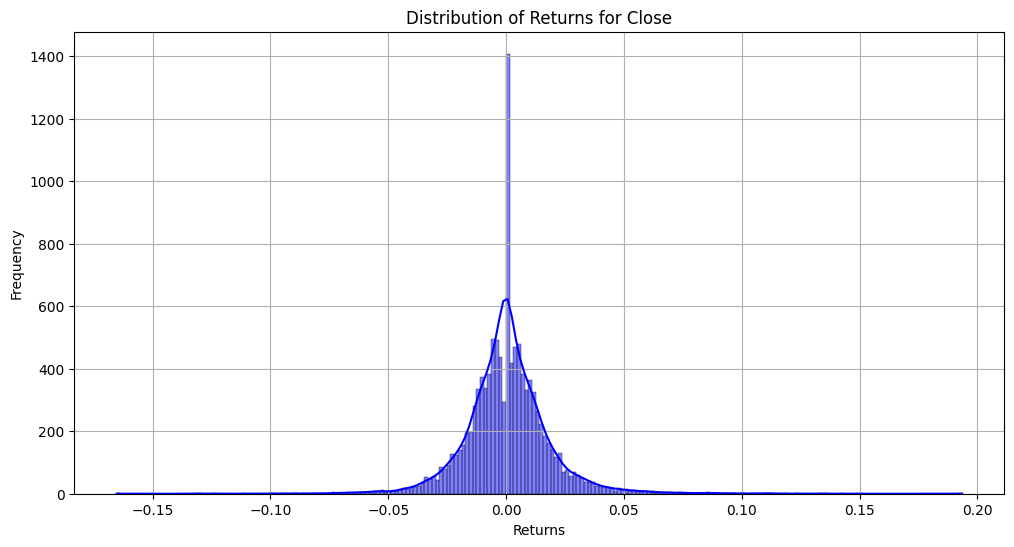

In [27]:
eda.plot_returns_distribution("Close")


The graph titled **"Distribution of Returns for Close"** visualizes the **distribution of daily returns** for the **closing price** of a stock. Daily returns are calculated as the percentage change in the closing price from one day to the next. The graph uses a **histogram** with a **kernel density estimate (KDE)** overlay to show the frequency of different return values.

- **X-axis**: Represents the **daily returns** (percentage change in closing price).
- **Y-axis**: Represents the **frequency** of returns (how often each return value occurs).


**Key Insights from Visualization**
1. **Shape of the Distribution**:
   - The distribution of returns is **approximately symmetric** but slightly **right-skewed**, meaning there are more frequent small positive returns and occasional large positive returns.
   - The peak of the distribution is around **0.00**, indicating that the most common daily return is close to zero (i.e., no significant change in price).

2. **Volatility**:
   - The spread of the distribution indicates the **volatility** of the stock. A wider spread suggests higher volatility, while a narrower spread suggests lower volatility.
   - The tails of the distribution extend to both positive and negative returns, indicating that the stock experiences both significant gains and losses.

3. **Anomalies**:
   - The presence of **outliers** in the tails of the distribution (e.g., returns beyond ±0.15) suggests that the stock occasionally experiences extreme price movements, which could be due to market events or anomalies.

4. **Central Tendency**:
   - The mean and median of the distribution are likely close to **0.00**, indicating that, on average, the stock's daily returns are centered around zero.



**Analysis of Trends, Seasonality, and Anomalies**
1. **Trends**:
   - The distribution does not show a clear **trend** because it represents the frequency of returns rather than their progression over time. However, the shape of the distribution provides insights into the stock's typical behavior.

2. **Seasonality**:
   - There is no evidence of **seasonality** in the graph. The distribution of returns does not show recurring patterns at regular intervals (e.g., yearly or quarterly).

3. **Anomalies**:
   - **Outliers**: The presence of extreme returns in the tails of the distribution suggests that the stock occasionally experiences significant price movements, which could be due to market anomalies or events.
   - **Skewness**: The slight right skewness indicates that the stock is more likely to experience large positive returns than large negative returns.

---

### **Rolling Skewness and Kurtosis**

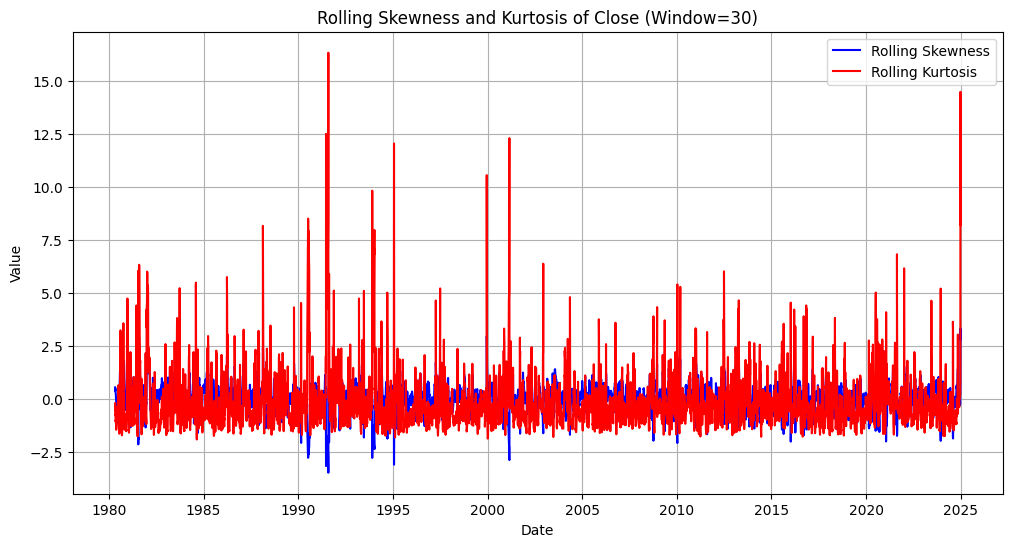

In [28]:
eda.plot_rolling_skewness_kurtosis("Close")


The graph titled **"Rolling Skewness and Kurtosis of Close (Window=30)"** visualizes the **rolling skewness** and **rolling kurtosis** of the **closing price** of a stock over time. These metrics are calculated over a rolling window of 30 days, which smooths out short-term fluctuations and highlights longer-term trends in the distribution of the closing price.

- **X-axis**: Represents time (from 1980 to 2025).
- **Y-axis**: Represents the **value** of skewness and kurtosis.
  - **Skewness**: Measures the asymmetry of the distribution of closing prices.
    - A skewness of **0** indicates a symmetric distribution.
    - A **positive skewness** indicates a longer tail on the right (more frequent large positive returns).
    - A **negative skewness** indicates a longer tail on the left (more frequent large negative returns).
  - **Kurtosis**: Measures the "tailedness" of the distribution of closing prices.
    - A kurtosis of **3** indicates a normal distribution.
    - A **kurtosis greater than 3** indicates heavier tails (more extreme values).
    - A **kurtosis less than 3** indicates lighter tails (fewer extreme values).



**Key Insights from Visualization**
1. **Skewness Trends**:
   - The rolling skewness fluctuates around **0**, indicating that the distribution of closing prices is generally symmetric but occasionally exhibits slight asymmetry.
   - There are periods of **positive skewness** (e.g., around 2000 and 2020), suggesting that the stock experienced more frequent large positive returns during these periods.
   - There are also periods of **negative skewness** (e.g., around 2008), suggesting that the stock experienced more frequent large negative returns during these periods.

2. **Kurtosis Trends**:
   - The rolling kurtosis is generally **greater than 3**, indicating that the distribution of closing prices has heavier tails than a normal distribution. This suggests that the stock frequently experiences extreme price movements.
   - The kurtosis shows significant fluctuations, with peaks around **2000** and **2008**, indicating periods of extreme volatility.

3. **Volatility and Anomalies**:
   - The peaks in kurtosis correspond to periods of **high volatility** and **market anomalies**, such as the **Dot-com Bubble (2000)** and the **2008 Financial Crisis**.
   - The skewness and kurtosis metrics provide insights into the **risk** and **return characteristics** of the stock over time.



**Analysis of Trends, Seasonality, and Anomalies**
1. **Trends**:
   - The rolling skewness and kurtosis show **no clear long-term trend** but exhibit significant fluctuations over time. This suggests that the distribution of closing prices changes dynamically based on market conditions.
   - The kurtosis is consistently **greater than 3**, indicating that the stock frequently experiences extreme price movements.

2. **Seasonality**:
   - There is no evidence of **seasonality** in the graph. The skewness and kurtosis do not show recurring patterns at regular intervals (e.g., yearly or quarterly).

3. **Anomalies**:
   - **2000**: The peaks in skewness and kurtosis around 2000 likely correspond to the **Dot-com Bubble**, which caused extreme price movements in technology and growth stocks.
   - **2008**: The peaks in skewness and kurtosis around 2008 likely correspond to the **2008 Financial Crisis**, which led to widespread market instability and extreme price movements.
   - **2020**: The increase in skewness and kurtosis around 2020 may reflect the impact of the **COVID-19 pandemic** on the stock market.


---

### **Cumulative Return Analysis**

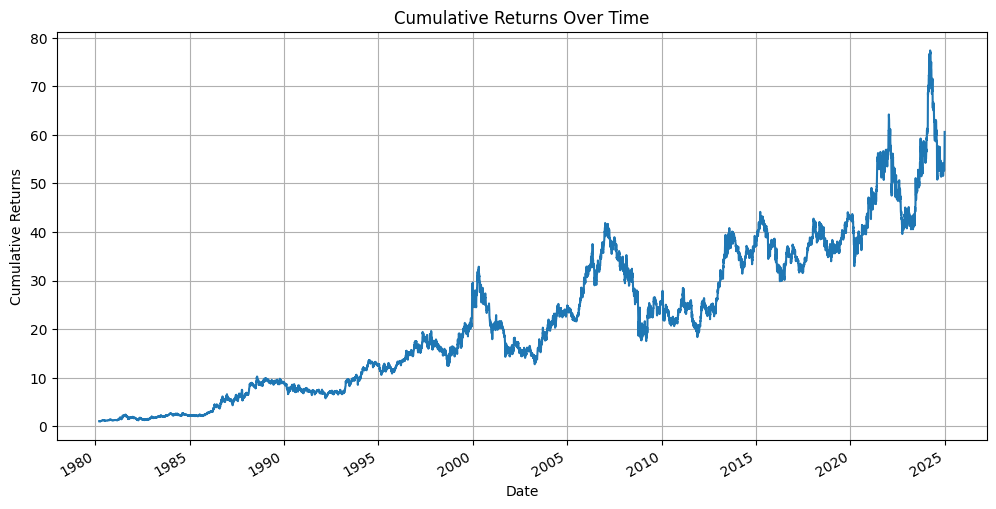

In [26]:
eda.plot_cumulative_returns("Close")


- This graph represents the **cumulative returns** of a stock over time.  
- The **x-axis** shows the date, ranging from **1980** to **2025**.  
- The **y-axis** represents cumulative returns, showing the growth of an investment over time.

**Key Insights from Visualization**
- The stock price shows an overall **upward trend**, indicating **long-term growth**.
- There are periods of rapid increase (e.g., around 2000, 2010, and after 2020), which may be due to market booms or company performance improvements.
- There are major dips, such as around 2008 and 2020, possibly related to financial crises or market corrections.
- Recent volatility suggests higher fluctuations in stock price.

**Trend & Anomalies**
- **Long-Term Trend:** A steady increase in stock value over decades.
- **Anomalies:** Sharp rises and drops indicate potential financial crises or major economic events.

---


### **Rolling Volatility Analysis**

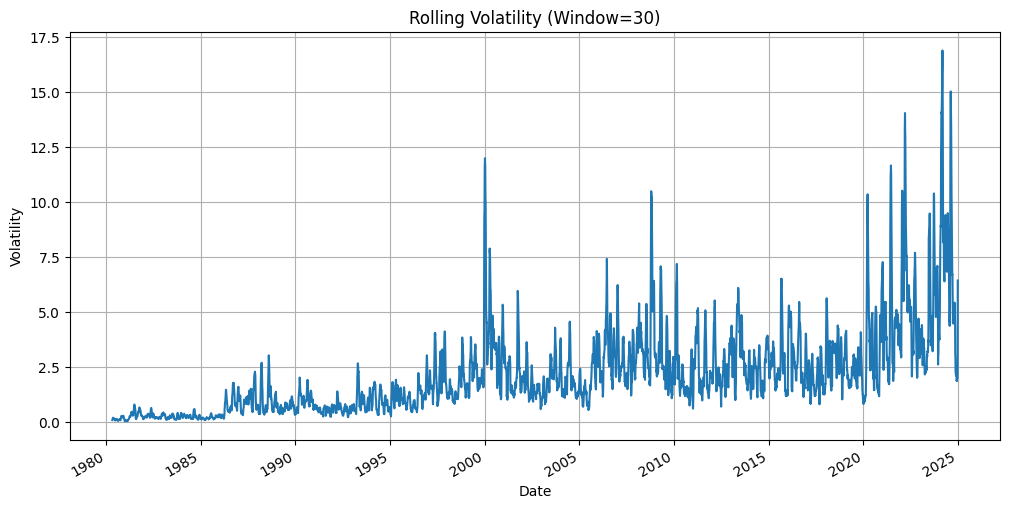

In [27]:
eda.plot_rolling_volatility("Close")


- The graph shows the **rolling volatility** of the stock's closing price over time.
- **Volatility** measures how much the stock price fluctuates. Higher volatility means the price changes a lot, while lower volatility means the price is more stable.
- The **x-axis** represents the **Date**, ranging from 2003 to 2025.
- The **y-axis** represents the **volatility** (measured as the standard deviation of the stock price over a 30-day window).

**Visualizations of Key Patterns and Relationships:**
- The graph shows how the stock's volatility changes over time.
- A **30-day rolling window** is used, meaning the volatility is calculated based on the past 30 days of data.

**Analysis of Trends, Seasonality, and Anomalies:**
- **Trends:** The volatility fluctuates over time, with periods of high volatility (e.g., around 2008-2009 and 2020) and periods of low volatility (e.g., around 2012-2015).
- **Seasonality:** There is no clear seasonal pattern in the volatility. However, the spikes in volatility often correspond to major market events (e.g., the 2008 financial crisis and the 2020 COVID-19 pandemic).
- **Anomalies:** The spikes in volatility around 2008-2009 and 2020 are notable anomalies, likely caused by significant market disruptions.

---

### **Target Variable Distribution**

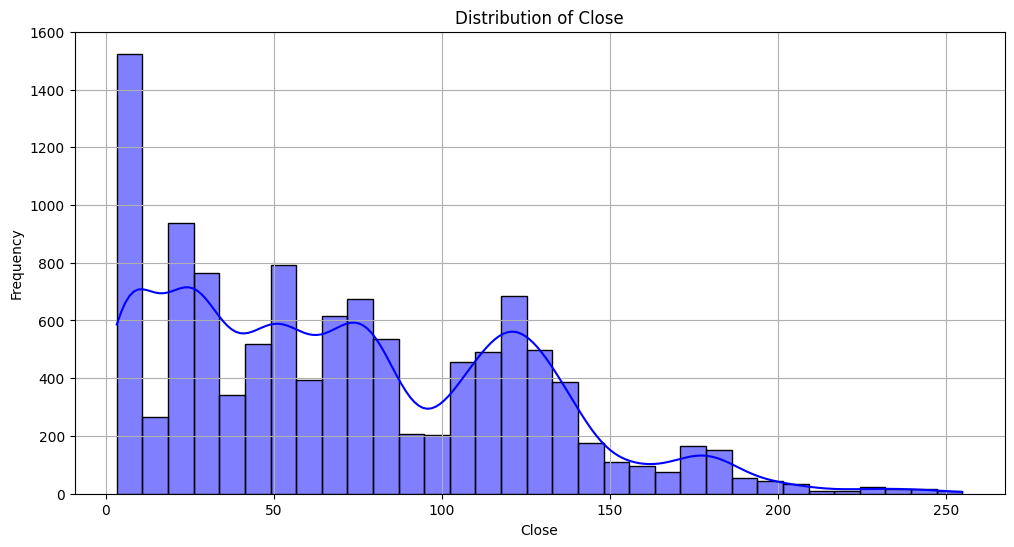

In [28]:
eda.plot_histogram("Close")


- The graph shows the **distribution** of the stock's **closing prices**.
- The **x-axis** represents the **closing price** of the stock.
- The **y-axis** represents the **frequency** (how often each closing price occurs).

**Visualizations of Key Patterns and Relationships:**
- The graph is a **histogram**, which shows how often different closing prices occur.
- The shape of the histogram tells us about the distribution of the closing prices.

**Analysis of Trends, Seasonality, and Anomalies:**
- **Trends:** The closing prices are mostly concentrated in a specific range (e.g., between 50 and 150), indicating that the stock price tends to stay within this range most of the time.
- **Seasonality:** There is no seasonality in this graph because it shows the distribution of prices, not their changes over time.
- **Anomalies:** There are some outliers (e.g., closing prices above 200), which are less frequent and could represent unusual market conditions.

---

### **KDE Analysis of the Target**

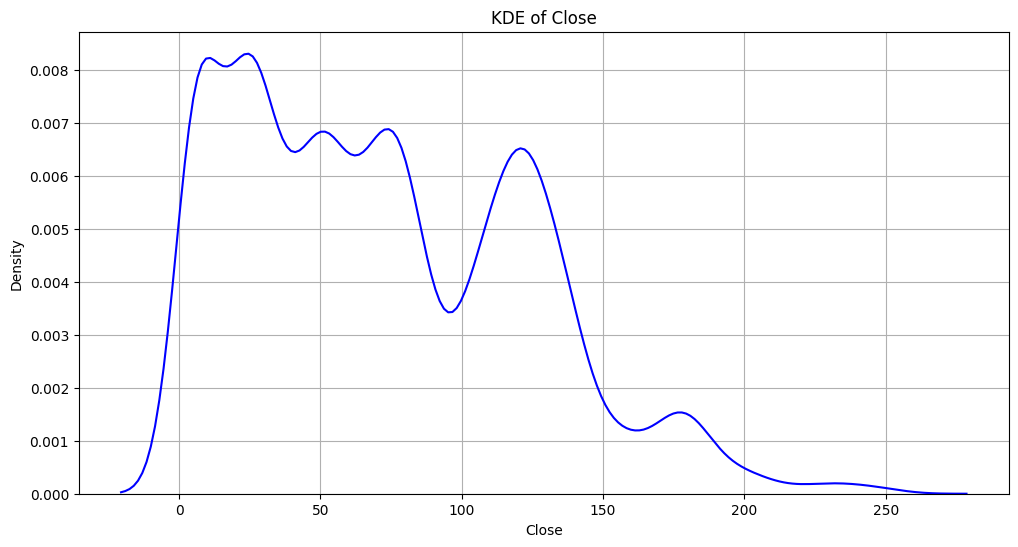

In [29]:
eda.plot_kde("Close")


- The graph shows the **Kernel Density Estimate (KDE)** of the stock's **closing prices**.
- The **x-axis** represents the **closing price** of the stock.
- The **y-axis** represents the **density** (probability distribution) of the closing prices.

**Visualizations of Key Patterns and Relationships:**
- The KDE plot is a smoothed version of the histogram, showing the probability distribution of the closing prices.
- The peaks in the graph represent the most likely closing prices.

**Analysis of Trends, Seasonality, and Anomalies:**
- **Trends:** The KDE plot shows that the closing prices are most likely to be around 100, with a gradual decrease in probability as the prices move away from this range.
- **Seasonality:** There is no seasonality in this graph because it shows the probability distribution of prices, not their changes over time.
- **Anomalies:** The long tail on the right side of the graph (towards higher closing prices) indicates that there are some rare instances where the closing price is much higher than the average.

---

### **Lag Plot Analysis (Lag=1)**

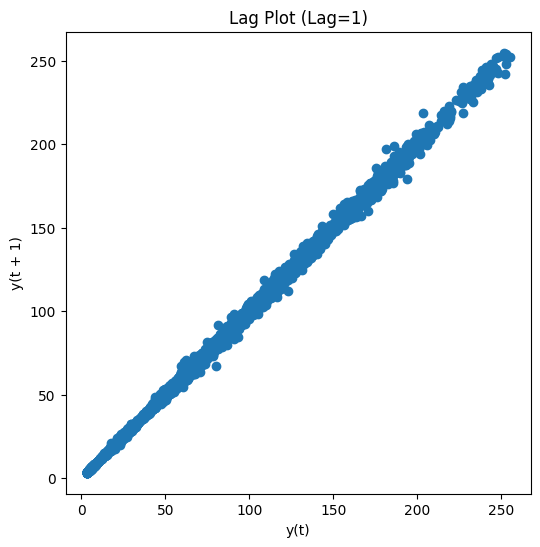

In [30]:
eda.plot_lag("Close")


- The graph is a **Lag Plot** with a lag of 1, meaning it compares the stock's closing price at time \( t \) with its closing price at time \( t+1 \) (the next day).
- The **x-axis** represents the **closing price at time \( t \)**.
- The **y-axis** represents the **closing price at time \( t+1 \)**.

**Visualizations of Key Patterns and Relationships:**
- The graph shows the relationship between the stock's closing price on one day and its closing price on the next day.
- If the points form a clear pattern (e.g., a straight line), it indicates a strong relationship between the two days' prices.

**Analysis of Trends, Seasonality, and Anomalies:**
- **Trends:** The points in the graph show a positive trend, meaning that if the stock price is high on one day, it is likely to be high on the next day as well.
- **Seasonality:** There is no seasonality in this graph because it compares prices on consecutive days, not over longer periods.
- **Anomalies:** There are some points that deviate from the general trend, which could represent unusual price movements.

---

### **Scatter Plot**

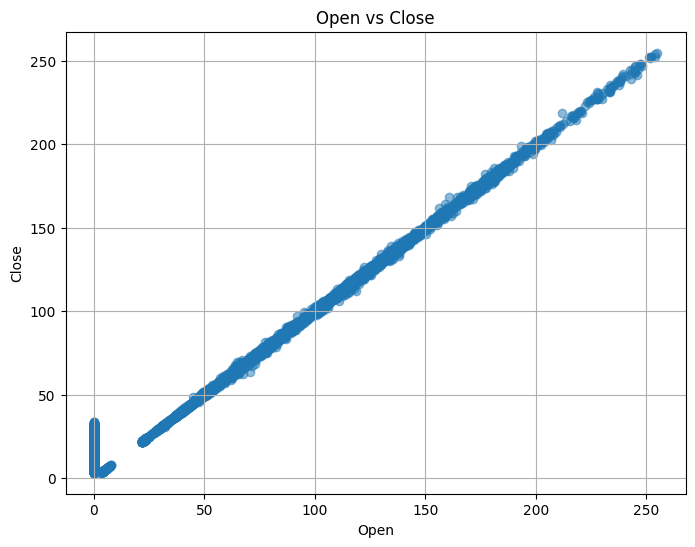

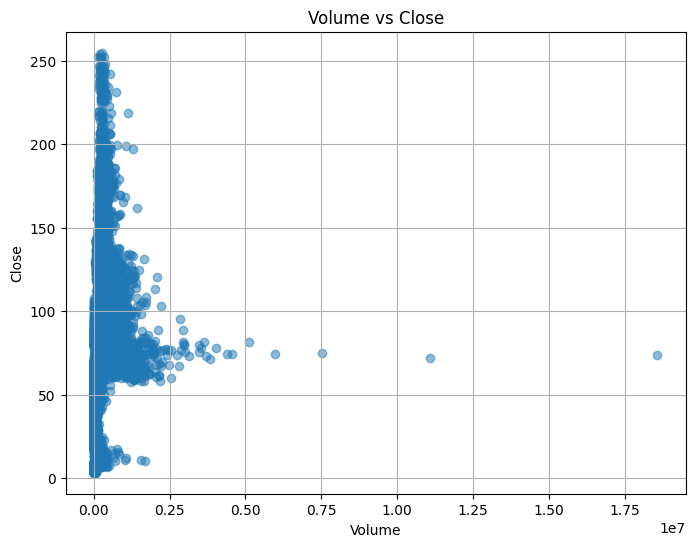

In [32]:
eda.plot_scatter("Open", "Close")
eda.plot_scatter("Volume","Close")

### **Missing Value Analysis**

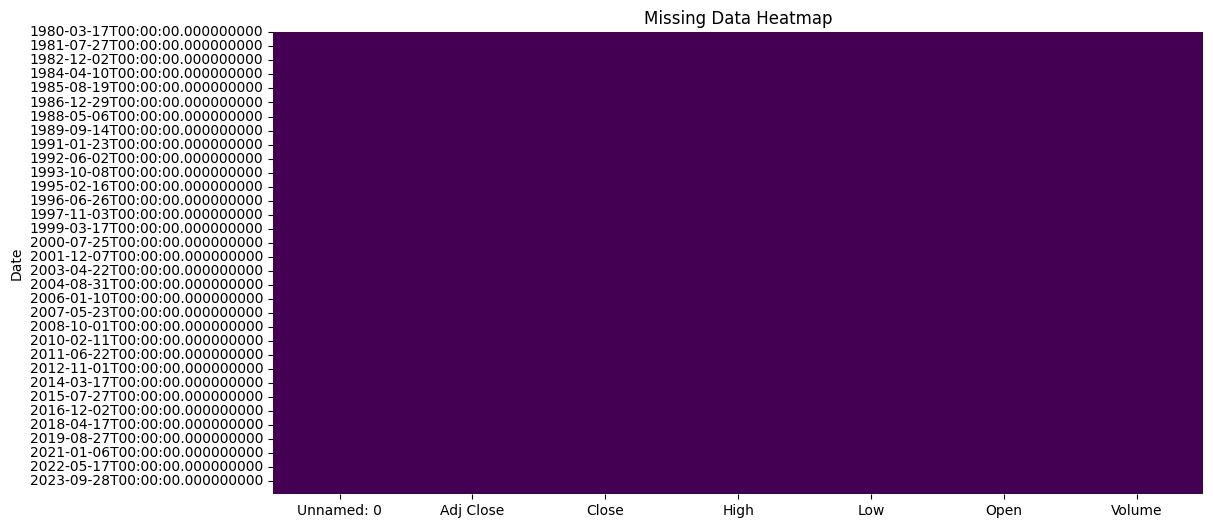

In [38]:
eda.plot_missing_data_heatmap()


- The graph is a **heatmap** that shows whether there are any missing values in the dataset.
- The **x-axis** represents the **columns** of the dataset (e.g., "Adj Close," "Close," "High," "Low," "Open," "Volume").
- The **y-axis** represents the **dates** (rows) in the dataset.
- The color of each cell indicates whether the data is missing (e.g., yellow for missing, blue for present).

**Visualizations of Key Patterns and Relationships:**
- We already handle the missing values in the dataset therefore, heatmap shows that there are **no missing values** in the dataset, as all cells are uniformly colored (likely blue).
- This indicates that the dataset is complete and ready for analysis.


**Anomalies:** There are no anomalies because the dataset is complete.

---

### **Pair Plot**

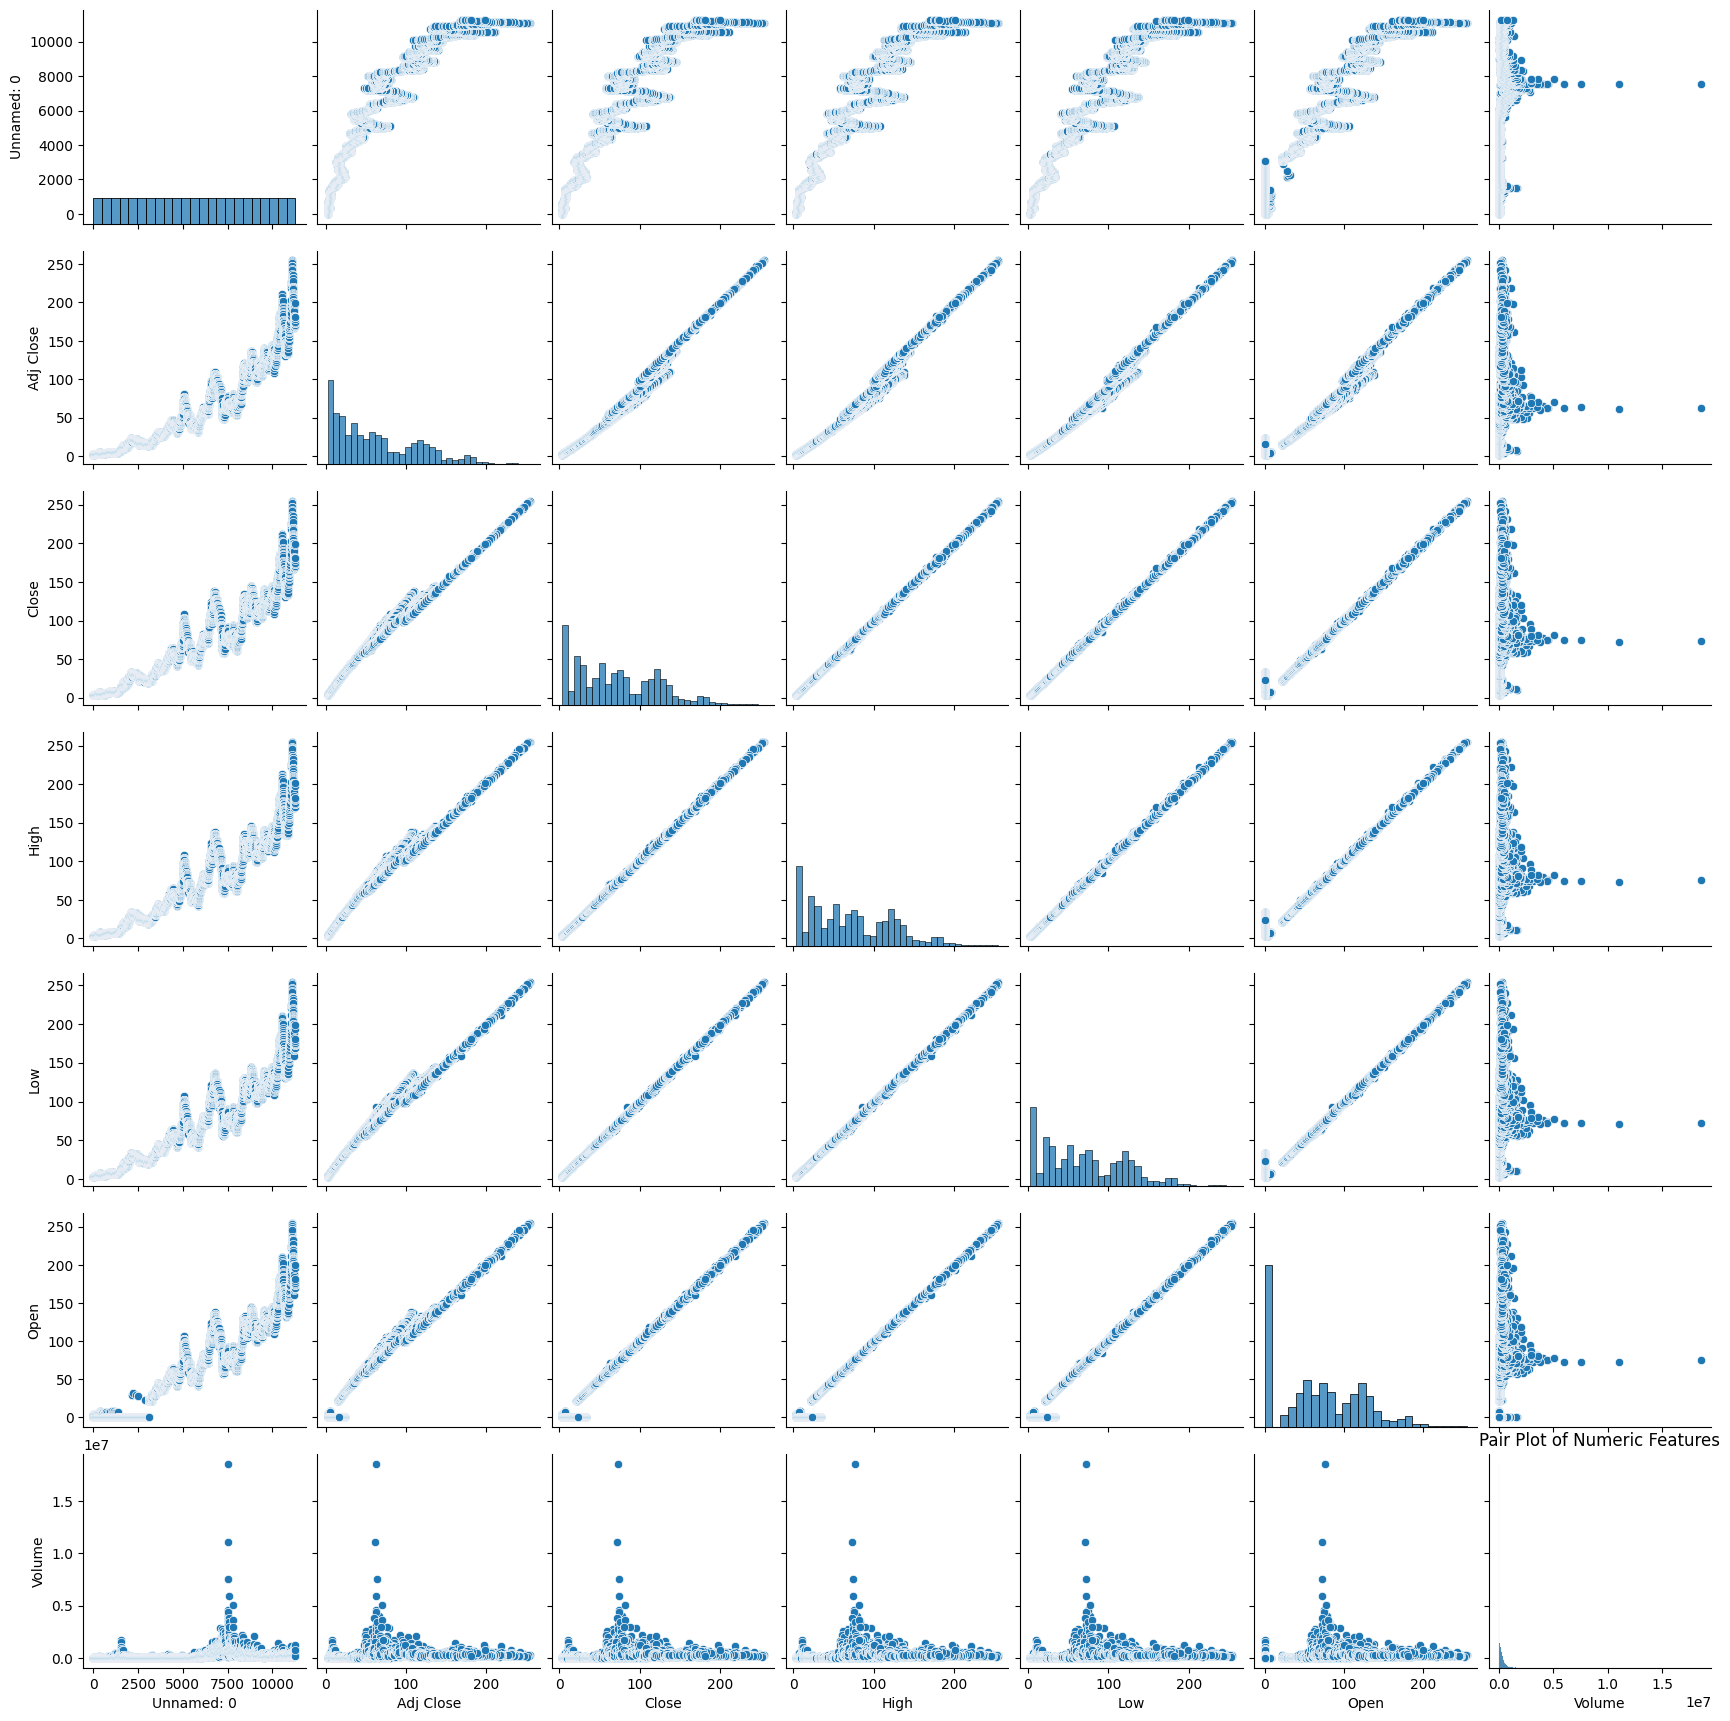

In [39]:
eda.plot_pairplot()



##### **Explanation of the Pair Plot**

Each row and column in the grid represents a different **numerical feature**. The diagonal contains **histograms** showing the distribution of individual features, while the **scatter plots** show pairwise relationships between them.

**Features in the Plot**
From the labels, the dataset includes:
- **Unnamed: 0** (probably an index column)
- **Adj Close** (Adjusted closing price of the stock)
- **Close** (Closing price)
- **High** (Highest price of the stock for the day)
- **Low** (Lowest price of the stock for the day)
- **Open** (Opening price of the stock for the day)
- **Volume** (Number of shares traded)

##### **Key Observations**
**Histograms (Diagonal)**
- Each histogram represents the distribution of a single feature.
- The **Adj Close**, **Close**, **High**, **Low**, and **Open** prices all follow an increasing trend, indicating long-term stock growth.
- **Volume** has a right-skewed distribution, meaning a few days had extremely high trading activity.

**Strong Correlations (Scatter Plots)**
- The **Close**, **High**, **Low**, **Open**, and **Adj Close** prices show a perfect linear relationship with each other.
- This is expected, as these values are closely related to stock performance and differ slightly due to market fluctuations.

**Volume vs Price**
- The scatter plots involving **Volume** appear more scattered, meaning trading volume does not have a strong direct correlation with **stock price**.
- Some extreme **outliers** in **Volume** suggest a few high-trading days, possibly due to major financial events or news.


---


### **Candlestick Chart**

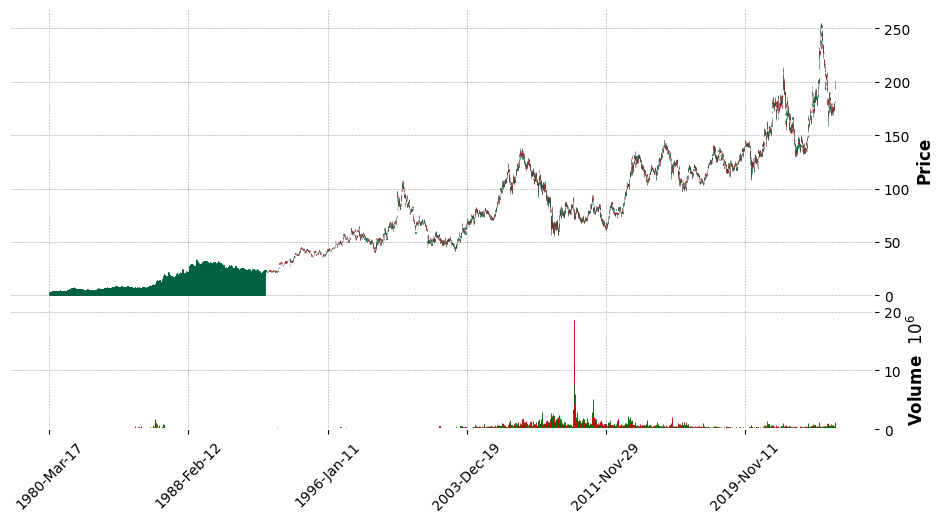

In [40]:
eda.plot_candlestick()




   - The candlestick chart visualizes the price movements of the stock over time. Each candlestick represents a specific time period (e.g., one day), and the color indicates whether the price increased (green/white) or decreased (red/black).
   - The **volume bars** at the bottom show the trading volume for each period, which can help confirm the strength of a price movement.

**Visualizations of key patterns and relationships**:
   - **Trends**: The chart helps identify upward (bullish) or downward (bearish) trends in the stock price over time.
   - **Support and Resistance Levels**: These are price levels where the stock tends to find support (stops falling) or resistance (stops rising).
   - **Candlestick Patterns**: Certain patterns (e.g., Doji, Hammer, Engulfing) can provide insights into potential reversals or continuations in the price trend.
   - **Volume Confirmation**: High trading volume during a price movement can confirm the strength of the movement, while low volume may indicate weak momentum.

**Analysis of trends, seasonality, and anomalies**:
   - **Trends**: The chart can reveal long-term trends (e.g., a series of green candlesticks indicating a bullish trend) or short-term fluctuations.
   - **Seasonality**: While candlestick charts are not typically used to identify seasonality, recurring patterns could hint at seasonal behavior.
   - **Anomalies**: Sudden spikes or drops in price, accompanied by high volume, could indicate significant market events (e.g., earnings reports, news announcements).

---

### **Corelation HeatMap**

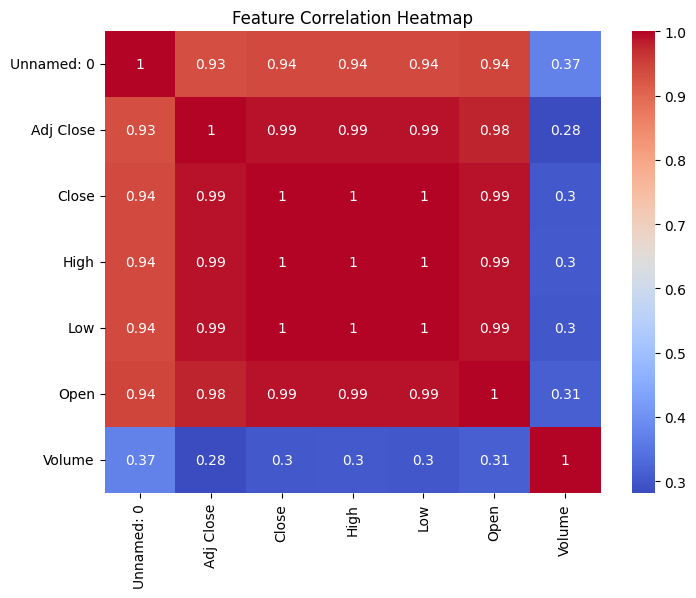

In [21]:
eda.plot_correlation_heatmap()

##### **Insights from the Feature Correlation Heatmap**

**What the heatmap represents**:
   - The heatmap shows the pairwise correlation coefficients between different features in the dataset. Each cell represents the correlation between two features.
   - Features included: **Unnamed: 0**, **Adj Close**, **Close**, **High**, **Low**, **Open**, and **Volume**.

**Visualizations of key patterns and relationships**:
   - **High Correlation (Close to 1)**:
     - **Adj Close**, **Close**, **High**, **Low**, and **Open** are highly correlated with each other (correlation coefficients between 0.93 and 1.0).
     - Example: **Close** and **High** have a perfect positive correlation (1.0).
   - **Low Correlation (Close to 0)**:
     - **Volume** has low correlation with all other features (correlation coefficients between 0.28 and 0.37).

**Analysis of trends and relationships**:
   - **Price Features**: The high correlation between price-related features indicates they are closely related, which is typical for stock price data.
   - **Volume**: The low correlation between **Volume** and price-related features suggests that trading volume does not directly influence price movements in a linear way.
   - **Multicollinearity**: The high correlation between price-related features may lead to multicollinearity in models. To address this:
     - Remove redundant features (e.g., keep only **Close**).
     - Use dimensionality reduction techniques like PCA.




## **Feature Engineering and Feature Creation**

In [43]:
class TimeSeriesPreprocessor:
    def __init__(self, data, target_column='close'):
        """
        Initialize the Preprocessor with data and target column.
        """
        self.data = data.copy()
        self.target_column = target_column
        self.scaler1 = MinMaxScaler(feature_range=(0, 1))
        self.scaler2 = MinMaxScaler(feature_range=(0, 1))

    def handle_outliers(self, lower_limit=0.005, upper_limit=0.005):
        """
        Uses Winsorization to cap outliers at lower and upper quantiles.
        """
        self.data[self.target_column] = winsorize(self.data[self.target_column], 
                                                  limits=[lower_limit, upper_limit])
    
    def compute_moving_averages(self):
        """
        Adds 5-day, 10-day, and 50-day moving averages.
        """
        for window in [5, 10, 50]:
            self.data[f'ma_{window}'] = self.data[self.target_column].rolling(window=window).mean()
    
    def compute_volatility(self, window=10):
        """
        Computes rolling standard deviation (volatility) over a given window.
        """
        self.data['volatility'] = self.data[self.target_column].rolling(window=window).std()

    def compute_rsi(self, window=14):
        """
        Computes Relative Strength Index (RSI) for stock momentum.
        """
        delta = self.data[self.target_column].diff(1)
        gain, loss = np.where(delta > 0, delta, 0), np.where(delta < 0, -delta, 0)
        avg_gain = pd.Series(gain).rolling(window=window).mean()
        avg_loss = pd.Series(loss).rolling(window=window).mean()
        rs = avg_gain / avg_loss
        self.data['rsi'] = 100 - (100 / (1 + rs))

    def compute_ema(self):
        """
        Adds 10-day and 50-day Exponential Moving Averages.
        """
        for window in [10, 50]:
            self.data[f'ema_{window}'] = self.data[self.target_column].ewm(span=window, adjust=False).mean()

    def compute_daily_return(self):
        """
        Computes daily percentage change in closing price.
        """
        self.data['daily_return'] = self.data[self.target_column].pct_change()

    def add_date_features(self):
        """
        Extracts year, month, day, and weekday from the date column.
        """
        self.data['year'] = self.data['date'].dt.year
        self.data['month'] = self.data['date'].dt.month
        self.data['day'] = self.data['date'].dt.day
        self.data['weekday'] = self.data['date'].dt.weekday

    def handle_missing_values(self):
        """
        Fills missing values using backward fill.
        """
        self.data.fillna(method='bfill', inplace=True)

    def normalize_features(self, feature_columns , target_column):
        """
        Normalizes given feature columns using MinMaxScaler.
        """
        self.data[target_column] = self.scaler1.fit_transform(self.data[[target_column]])
        self.data[feature_columns] = self.scaler2.fit_transform(self.data[feature_columns])
        return self.scaler1

    def create_stacked_sliding_window(self, window_sizes=[30, 60, 90], split_ratio=0.8):
        """
        Creates input sequences (X) and output labels (y) using multiple window sizes.
        Ensures training data is strictly before test data (no data leakage).
        """
        # Ensure we split while keeping time order
        split_idx = int(len(self.data) * split_ratio)
        
        # Keep only training samples that don't use future data
        train_data = self.data.iloc[:split_idx]
        test_data = self.data.iloc[split_idx:]  # Test data starts AFTER train_data

        # Feature columns
        feature_columns = [self.target_column, 'ma_5', 'ma_10', 'ma_50', 'volatility', 'rsi', 'ema_10', 'ema_50', 'daily_return']

        def generate_windows(data):
            X, y = [], []
            for i in range(max(window_sizes), len(data) - 5):  # Ensure future prediction window
                stacked_windows = []
                for window_size in window_sizes:
                    window_data = data[feature_columns].iloc[i - window_size:i].values
                    # Padding smaller windows
                    if window_size < max(window_sizes):
                        padding = np.zeros((max(window_sizes) - window_size, window_data.shape[1]))
                        window_data = np.vstack([padding, window_data])
                    stacked_windows.append(window_data)
                X.append(np.hstack(stacked_windows))
                y.append(data[self.target_column].iloc[i + 5])  # Predicting 5 days ahead
            return np.array(X), np.array(y)

        # Apply the sliding window
        X_train, y_train = generate_windows(train_data)
        X_test, y_test = generate_windows(test_data)

        return X_train, y_train, X_test, y_test

    def process(self):
        """
        Runs all preprocessing steps sequentially.
        """
        self.handle_outliers()
        self.compute_moving_averages()
        self.compute_volatility()
        self.compute_rsi()
        self.compute_ema()
        self.compute_daily_return()
        self.add_date_features()
        self.handle_missing_values()

        #feature_columns = [ 'ma_5', 'ma_10', 'ma_50', 'volatility', 'rsi', 'ema_10', 'ema_50', 'daily_return']
        #self.scaler = self.normalize_features(feature_columns , self.target_column)

        return self.data 



In [44]:
# rename the columns
df = df.rename(columns={'Date': 'date', 'Close': 'close'})

# Initialize Preprocessor
preprocessor = TimeSeriesPreprocessor(df, target_column='close')

# Process Data
processed_data  = preprocessor.process()

scaler = MinMaxScaler(feature_range=(0, 1))
scaler2 = MinMaxScaler(feature_range=(0, 1))
processed_data['close'] = scaler.fit_transform(processed_data[['close']])
processed_data[['close','ma_5', 'ma_10', 'ma_50', 'volatility', 'rsi', 'ema_10', 'ema_50', 'daily_return']] = scaler2.fit_transform(processed_data[['close','ma_5', 'ma_10', 'ma_50', 'volatility', 'rsi', 'ema_10', 'ema_50', 'daily_return']])

processed_data['close']

0        0.000000
1        0.000000
2        0.000000
3        0.000000
4        0.000000
           ...   
11286    0.781171
11287    0.791382
11288    0.795771
11289    0.867117
11290    0.876791
Name: close, Length: 11291, dtype: float64

In [107]:
# Create sliding window sequences
X_train, y_train, X_test, y_test = preprocessor.create_stacked_sliding_window(window_sizes=[30, 60, 90], split_ratio=0.85)

print("Processed Data Sample:")
print(processed_data.head())

print(f"X_train Shape: {X_train.shape}, y Shape: {y_test.shape}")

Processed Data Sample:
   Unnamed: 0       date  Adj Close  close      High       Low      Open  \
0           0 1980-03-17   2.296798    0.0  3.344743  3.291227  0.000000   
1           1 1980-03-18   2.306134    0.0  3.358122  3.304606  0.000000   
2           2 1980-03-19   2.306134    0.0  3.304606  3.304606  3.304606   
3           3 1980-03-20   2.306134    0.0  3.358122  3.304606  0.000000   
4           4 1980-03-21   2.362154    0.0  3.438396  3.384880  0.000000   

    Volume  ma_5  ma_10  ma_50  volatility  rsi  ema_10  ema_50  daily_return  \
0  41109.0   0.0    0.0    0.0         0.0  1.0     0.0     0.0      0.460544   
1   9343.0   0.0    0.0    0.0         0.0  1.0     0.0     0.0      0.460544   
2      0.0   0.0    0.0    0.0         0.0  1.0     0.0     0.0      0.460544   
3  10277.0   0.0    0.0    0.0         0.0  1.0     0.0     0.0      0.460544   
4   8409.0   0.0    0.0    0.0         0.0  1.0     0.0     0.0      0.460544   

   year  month  day  weekday  
0 

## **Model Selection, Building and Evaluation**

#### **Model Selection: Why RNN with LSTM?**
Since the dataset contains **long-term patterns and sequential dependencies**, a **Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM)** is the most suitable model.

##### **Why LSTM?**
- **LSTM networks** are designed to capture **long-term dependencies** in time series data.
- They help in **avoiding vanishing gradient problems**, which are common in simple RNNs.
- LSTMs are effective for **predicting stock prices based on past trends**.

##### **Expected Benefits of LSTM Model**
- Captures **long-term dependencies** in stock prices.  
- Can **handle seasonality and trends** in financial data.  
- Useful for detecting **anomalies and major market events**.  
- Helps in building **robust stock price forecasting models**.

In [ ]:
# use optuana to chose the best model hyperparameters

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    num_lstm_layers = trial.suggest_int("num_lstm_layers", 1, 3)  # Number of LSTM layers
    lstm_units = trial.suggest_categorical("lstm_units", [32, 64, 128])  # LSTM Units
    dense_units = trial.suggest_categorical("dense_units", [64, 128, 256])  # Dense Units
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)  # Dropout
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)  # Learning rate
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])  # Batch size

    # Build the model
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

    for _ in range(num_lstm_layers - 1):  # Add extra LSTM layers if needed
        model.add(LSTM(lstm_units, return_sequences=False if _ == num_lstm_layers - 2 else True))

    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Output layer

    # Compile model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    # Train the model
    history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

    # Return the validation loss
    return min(history.history["val_loss"])

# Run the Optuna study
study = optuna.create_study(direction="minimize")  # We want to minimize validation loss
study.optimize(objective, n_trials=20)  # Run 20 trials (can increase for better results)

# Print the best hyperparameters
print("Best Hyperparameters:", study.best_params)


[I 2025-03-08 11:37:45,740] A new study created in memory with name: no-name-f5e48162-2d23-4fdb-ab2c-7bbd630a5a12
[I 2025-03-08 11:44:08,742] Trial 0 finished with value: 0.002534107305109501 and parameters: {'num_lstm_layers': 3, 'lstm_units': 128, 'dense_units': 64, 'dropout_rate': 0.32374367179335073, 'learning_rate': 0.0015043140297390579, 'batch_size': 64}. Best is trial 0 with value: 0.002534107305109501.
[I 2025-03-08 11:47:02,145] Trial 1 finished with value: 0.002688538283109665 and parameters: {'num_lstm_layers': 3, 'lstm_units': 64, 'dense_units': 256, 'dropout_rate': 0.37499396422925846, 'learning_rate': 0.0023708748449123096, 'batch_size': 64}. Best is trial 0 with value: 0.002534107305109501.
[I 2025-03-08 11:53:42,664] Trial 2 finished with value: 0.002530772238969803 and parameters: {'num_lstm_layers': 3, 'lstm_units': 64, 'dense_units': 256, 'dropout_rate': 0.35647436968778423, 'learning_rate': 0.0001673535184006329, 'batch_size': 16}. Best is trial 2 with value: 0.002

Best Hyperparameters: {'num_lstm_layers': 2, 'lstm_units': 128, 'dense_units': 256, 'dropout_rate': 0.11816665501568609, 'learning_rate': 0.00598379480071927, 'batch_size': 32}


#### **Build the Model with Best Hyperparameters**

In [ ]:
# Get input shape dynamically
input_shape = (X_train.shape[1], X_train.shape[2]) 
 

# Build the LSTM Model
model2 = Sequential()
model2.add(LSTM(128, return_sequences=True, input_shape=input_shape))
model2.add(LSTM(128, return_sequences=False))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.11816665501568609))
model2.add(Dense(1))


# Compile the Model with Optimized Learning Rate
model2.compile(optimizer=Adam(learning_rate=0.00598379480071927), loss='mean_squared_error')

# Print Model Summary
model2.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 90, 128)        │        79,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,737 (956.00 KB)

 Trainable params: 244,737 (956.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# Define a custom callback
class StopTrainingOnLowValLoss(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_loss') is not None and logs['val_loss'] < 0.001:
            print(f"\nStopping training: Validation loss ({logs['val_loss']:.6f}) < 0.001")
            self.model.stop_training = True

# Train the model with the callback
training2 = model2.fit(X_train, y_train, 
                     epochs=20, 
                     batch_size=32, 
                     validation_data=(X_test, y_test),
                     callbacks=[StopTrainingOnLowValLoss()])

Epoch 1/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 38s 120ms/step - loss: 0.0305 - val_loss: 0.0014
Epoch 2/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 31s 105ms/step - loss: 5.2794e-04 - val_loss: 0.0017
Epoch 3/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - loss: 4.1838e-04 - val_loss: 0.0012
Epoch 4/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 36s 122ms/step - loss: 4.3292e-04 - val_loss: 0.0024
Epoch 5/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 44s 147ms/step - loss: 3.5271e-04 - val_loss: 0.0013
Epoch 6/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 44s 147ms/step - loss: 3.6824e-04 - val_loss: 0.0033
Epoch 7/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 3.0366e-04
Stopping training: Validation loss (0.000897) < 0.001
297/297 ━━━━━━━━━━━━━━━━━━━━ 33s 113ms/step - loss: 3.0365e-04 - val_loss: 8.9691e-04


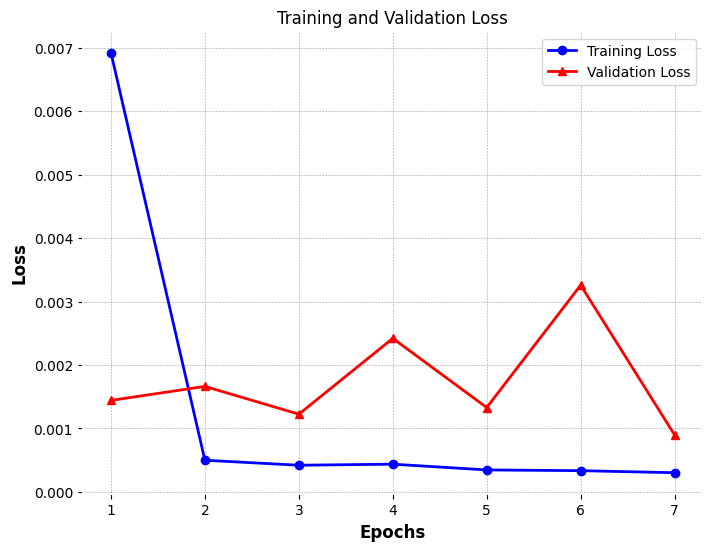

In [122]:
# Extract loss values
train_loss = training2.history['loss']
val_loss = training2.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot the loss values
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')  # 'bo-' means blue circles with lines
plt.plot(epochs, val_loss, 'r^-', label='Validation Loss')  # 'r^-' means red triangles with lines
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [123]:
# Make predictions

predictions_train = model2.predict(X_train)
predictions_test = model2.predict(X_test)

297/297 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


#### **Evaluation and Save the Result**

In [124]:
predictions_train = scaler.inverse_transform(predictions_train)
predictions_test = scaler.inverse_transform(predictions_test)

predictions_train_df = pd.DataFrame(predictions_train, columns=["Predictions"])
predictions_test_df = pd.DataFrame(predictions_test, columns=["Predictions"])

train = y_train.copy()
train = train.reshape(-1, 1)
test = y_test.copy()
test = test.reshape(-1, 1)

test = scaler.inverse_transform(test)
train = scaler.inverse_transform(train)

test = pd.DataFrame(test, columns=["close"])
train = pd.DataFrame(train, columns=["close"])

test['Predictions'] = predictions_test_df['Predictions']
train['Predictions'] = predictions_train_df['Predictions']

test['date'] = df['date'].iloc[-len(test):].values
train['date'] = df['date'].iloc[:len(train)].values



In [ ]:
# save the model
model2.save("../models/model.h5")

# Save the predictions to a CSV file
#train.to_csv("../predictions/train_predictions.csv", index=False)
test.to_csv("../predictions/test_predictions.csv", index=False)


In [126]:
def directional_accuracy(y_actual, y_pred):
    # Calculate directional accuracy (1 for correct direction, 0 for wrong direction)
    directions_actual = np.sign(np.diff(y_actual))
    directions_pred = np.sign(np.diff(y_pred))
    
    # Compute directional accuracy (same direction count / total)
    correct_direction = np.sum(directions_actual == directions_pred)
    directional_acc = correct_direction / len(directions_actual)
    return directional_acc



directional_acc_train = directional_accuracy(np.array(train["close"]),np.array(train["Predictions"]))
directional_acc_test = directional_accuracy(np.array(test["close"]),np.array(test["Predictions"]))

print("Directional Accuracy:")
print("Train:", directional_acc_train)
print("Test:", directional_acc_test)

rmse_train = np.sqrt(np.mean((np.array(train["close"]) - np.array(train["Predictions"])) ** 2))
rmse_test = np.sqrt(np.mean((np.array(test["close"])- np.array(test["Predictions"])) ** 2))

print("RMSE:")
print("Train:", rmse_train)
print("Test:", rmse_test)

Directional Accuracy:
Train: 0.4431112514472161
Test: 0.47434292866082606
RMSE:
Train: 2.8051471304568136
Test: 6.686876560219359


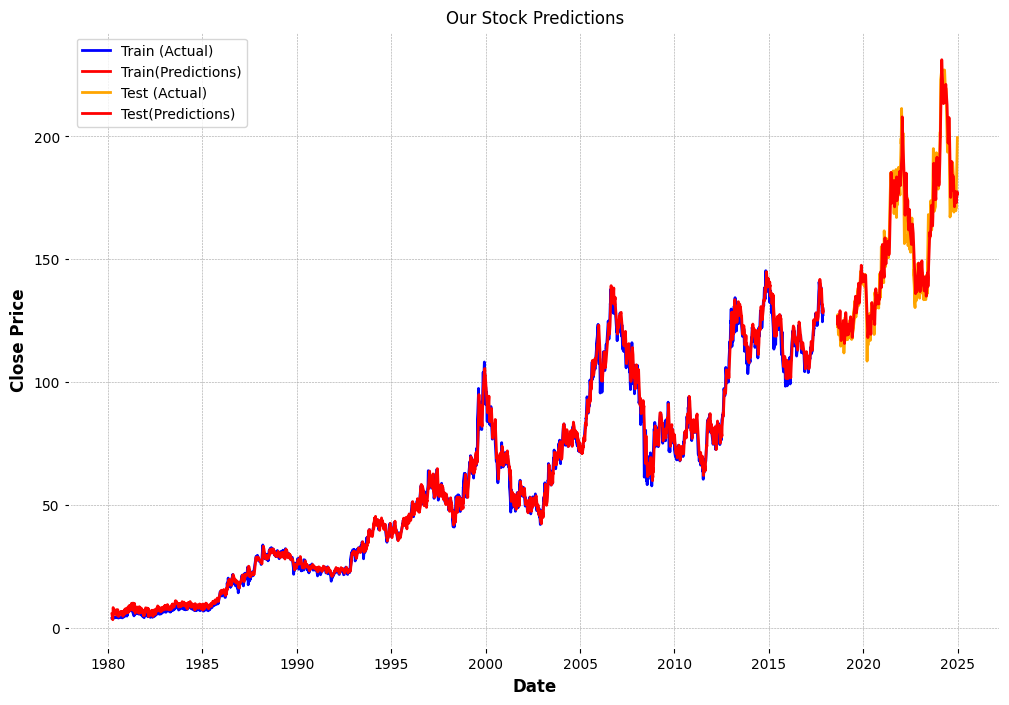

In [128]:
plt.figure(figsize=(12,8))
plt.plot(train['date'], train['close'], label="Train (Actual)", color='blue')
plt.plot(train['date'], train['Predictions'], label="Train(Predictions)", color='red')
plt.plot(test['date'], test['close'], label="Test (Actual)", color='orange')
plt.plot(test['date'], test['Predictions'], label="Test(Predictions)", color='red')
plt.title("Our Stock Predictions")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()
